In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pylab
import math
import sys
import operator
import inspect
import lmfit
from lmfit import Model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import signal
from scipy import fftpack
from scipy.integrate import trapz
from operator import itemgetter
from skimage import util
from scipy import stats
from numpy import NaN, Inf, arange, isscalar, asarray, array

w7x_te = []
w7x_te_n = []
w7x_zet = []
w7x_sigma = []
w7x_zf_nl = []
w7x_zf = []

##################################################    PEAK DETECTOR     ###############################################
def peakdet(v, delta, x = None):
    maxtab = []
    mintab = []
       
    if x is None:
        x = arange(len(v))
    
    v = asarray(v)
    
    if len(v) != len(x):
        sys.exit('Input vectors v and x must have same length')
    
    if not isscalar(delta):
        sys.exit('Input argument delta must be a scalar')
    
    if delta <= 0:
        sys.exit('Input argument delta must be positive')
    
    mn, mx = Inf, -Inf
    mnpos, mxpos = NaN, NaN
    
    lookformax = True
    
    for i in arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]
        
        if lookformax:
            if this < mx-delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn+delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True

    return array(maxtab), array(mintab)
##################################################    FITTING MODELS     ##############################################

def model(t, decay):  # , omega, resid):
    return np.exp(-t/decay)  # * np.cos(omega * t) + resid
gmodel = lmfit.Model(model)
def line(x, slope, intercept):
    """a line"""
    return 10**((slope*np.log(x))-intercept)
mod = Model(line)
def line2(x, slope, intercept):
    """a line"""
    return slope*x+intercept
def adjust_yaxis(ax,ydif,v):
    """shift axis ax by ydiff, maintaining point v at the same location"""
    inv = ax.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, ydif))
    miny, maxy = ax.get_ylim()
    miny, maxy = miny - v, maxy - v
    if -miny>maxy or (-miny==maxy and dy > 0):
        nminy = miny
        nmaxy = miny*(maxy+dy)/(miny+dy)
    else:
        nmaxy = maxy
        nminy = maxy*(miny+dy)/(maxy+dy)
    ax.set_ylim(nminy+v, nmaxy+v)
    
def align_yaxis(ax1, v1, ax2, v2):
    """adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1"""
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    adjust_yaxis(ax2,(y1-y2)/2,v2)
    adjust_yaxis(ax1,(y2-y1)/2,v1)
    
#################################################    NAME RETREIVER     ###############################################

def retrieve_name(var):
        """
        Gets the name of var. Does it from the out most frame inner-wards.
        :param var: variable to get name from.
        :return: string
        """
        for fi in reversed(inspect.stack()):
            names = [var_name for var_name, var_val in fi.frame.f_locals.items() if var_val is var]
            if len(names) > 0:
                return names[0]
#######################################################################################################################
####################################################    FUNCTIONS     #################################################
#######################################################################################################################

#################################################    W7X DIAGPLOTTER     ##############################################

def diag_plotter_w7x(kx, my_data, alldata=False, fig=True):
    
    integ = my_data[0, :]
    rmsvl = my_data[1, :]
    decay = my_data[2, :]
    osrat = my_data[3, :]
    burat = my_data[4, :]
    g1rat = my_data[5, :]
    g2rat = my_data[6, :]
    dcrat = my_data[7, :]
    perid = my_data[8, :]
    perbd = my_data[9, :]
    pekti = my_data[10, :]
    
    if fig == True:
        fig = plt.figure(figsize=(30, 20))
    else:
        fig = fig
        
    ax1 = fig.add_subplot(331)
    ax2 = fig.add_subplot(332)
    ax3 = fig.add_subplot(333)
    ax4 = fig.add_subplot(334)
    ax5 = fig.add_subplot(335)
    ax6 = fig.add_subplot(336)
    ax7 = fig.add_subplot(337)
    ax8 = fig.add_subplot(338)
    ax9 = fig.add_subplot(339)


    ########  top
    ax1.plot(kx, integ)
    ax2.plot(kx, rmsvl)
    ax3.plot(kx, decay)
    
    #ax1.set_xlabel('$k_{x} \\rho_{ti}$')
    #ax2.set_xlabel('$k_{x} \\rho_{ti}$')
    #ax3.set_xlabel('$k_{x} \\rho_{ti}$')

    ax1.title.set_text('Integral')
    ax2.title.set_text('RMS value')
    ax3.title.set_text('Decay length')

    ########  mid
    ax4.plot(kx, osrat)
    ax5.plot(kx, g2rat, label='Growth ratio')
    ax5.plot(kx, dcrat, label='Decay ratio')
    ax6.plot(kx, pekti, label='{0}'.format(retrieve_name(my_data)))
    
    #ax4.set_xlabel('$k_{x} \\rho_{ti}$')
    #ax5.set_xlabel('$k_{x} \\rho_{ti}$')
    #ax6.set_xlabel('$k_{x} \\rho_{ti}$')
    
    ax4.title.set_text('Overshoot ratio')
    # ax5.title.set_text('')
    ax6.title.set_text('Peak time')
    ax6.legend(loc="upper right")
    ax5.legend(loc="lower right")
    
    ########  bottom
    #ax3.title.set_text('RMS')
    ax7.plot(kx, g1rat)
    ax8.plot(kx, burat)
    ax9.plot(kx, perid, label='Decay Period')
    ax9.plot(kx, perbd, label='Bump Period')
    
    ax7.title.set_text('Bump growth ratio')
    ax8.title.set_text('Bump ratio')
    # ax9.title.set_text('Period')
    ax9.legend(loc="upper right")
    
    ax7.set_xlabel('$k_{x} \\rho_{ti}$')
    ax8.set_xlabel('$k_{x} \\rho_{ti}$')
    ax9.set_xlabel('$k_{x} \\rho_{ti}$')

    if alldata == False:
        fig.show()

    return fig
###############################################    TROUBLESHOOTER    ##################################################

def troubleshooter(E, t, f_s, spectrogram=True):
    #E = (data[:,1]*(1/data[0, 1]))
    #t = data[:, 0]
    #f_s = len(data[:, 0]) / data[-1, 0]
    X = fftpack.fft(E)
    freqs = fftpack.fftfreq(len(E)) * f_s

    fig = plt.figure(figsize=(13, 13))
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    ax1.stem(freqs, np.abs(X))
    ax1.set_xlabel('Frequency in Hertz [Hz]')
    ax1.set_ylabel('Frequency Domain (Spectrum) Magnitude')
    ax1.set_xlim(0, 0.55)  # f_s / 2)
    #ax2.set_ylim(-2, 2)
    ax2.set_xlim(0, 500)
    ax2.plot(t, E, label='{0}'.format(label))
    ax2.axhline(y=0, color='black', linestyle='dashed')
    
    maxtab, mintab, OS, BR, GR1, GR2, DR, PE, PE2, TP, a, b1, b2, e, i, o = nucleus_w7x(E, t, label, diag=True)
    
    if type(b1) == float and type(o) != float:
        n = ['a', 'e', 'i', 'o']
        x = np.array([a, e, i, o])[:,1]
        y = np.array([a, e, i, o])[:,0]
    elif type(b1) != float and type(o) == float:
        n = ['a', 'b1', 'b2', 'e', 'i']
        x = np.array([a, b1, b2, e, i])[:,1]
        y = np.array([a, b1, b2, e, i])[:,0]
    else:
        n = ['a', 'b1', 'b2', 'e', 'i', 'o']
        x = np.array([a, b1, b2, e, i, o])[:,1]
        y = np.array([a, b1, b2, e, i, o])[:,0]
    ax2.scatter(y,x, color='blue')
    for r, txt in enumerate(n):
        ax2.annotate(txt, (y[r], x[r]))
    ax2.scatter(e[0], e[1], color='green')
    ax2.scatter(maxtab[:, 0], maxtab[:, 1], color='red')
    ax2.scatter(mintab[:, 0], mintab[:, 1], color='blue')
    #ax2.set_xlim(-10, 100)
    print('Overshoot ratio (OS): ' + str(OS))
    print('Bump ratio (BR): ' + str(BR))
    print('Bump growth ratio (GR1): ' + str(GR1))
    print('2nd growth ratio (GR2): ' + str(GR2))
    print('Period (PE): ' + str(PE))
    print('Peak time (TP): ' + str(TP))
    fig.show()
    
    if spectrogram == True:
            ########  SPECTROGRAM
            M = 1024
            slices = util.view_as_windows(E, window_shape=(M,), step=2)
            win = np.hanning(M + 1)[:-1]
            slices = slices * win
            slices = slices.T
            spectrum = np.fft.fft(slices, axis=0)[:M // 2 + 1:-1]
            spectrum = np.abs(spectrum)
            S = np.abs(spectrum)
            S = 20 * np.log10(S / np.max(S))
            plt.figure(figsize=(13, 6.5))
            plt.imshow(S, origin='lower', cmap='viridis')
            plt.title(str(label), fontsize=30)
            plt.axis('tight')
            plt.ylabel('Frequency [Hz]')
            plt.xlabel('Time ($a / v_{ti}$)')
            plt.ylim([0, 100])
    plt.show()
    
    return 
##################################################    NUCLEUS W7X     #################################################
    
def nucleus(E, t, diag=False):
    # Peak detection
    maxtab, mintab = peakdet(E, 0.001, x=t)
    
    # A fitting to the peak values to get the decay coefficient:
    result = gmodel.fit(E[:150], t=t[:150], decay=10, nan_policy='propagate')

    # Can you guess the residual?
    if 0.95 <= np.abs(E[-1]/mintab[0, 1]) <= 1.02:
        print('residual? :' + str(mintab[0, 1]))
        
    # Maxpeaks
    a = maxtab[0, :]  # Initial point
    
    if np.shape(maxtab) != (2, 2):  # If there are more points than a and i:
        b1 = maxtab[1, :]  # Second Peak
        i = maxtab[2, :]            
    elif np.shape(maxtab) == (2, 2):
        i = maxtab[1, :]
        b1 = i
        print('i point is the first one')     
    
    # Minpeaks
    b2 = mintab[0, :]  # (Technically) The lowest point
        
    min_index, min_value = min(enumerate(mintab[:, 1]), key=operator.itemgetter(1))  
    f = mintab[min_index, :]  # This determines the minimum peak
    
    if np.shape(mintab) != (1, 2):
        e = mintab[1, :]
    else:
        e = f

    # The initial bump is not detected if the points e & i are both > 0.32
    if b1[0] > 60:
        i = b1
        if i[1] < 0:
            i = maxtab[2, :]
        e = b2
        b1, b2, BR = np.nan, np.nan, np.nan
        GR1, GR2, PE2 = np.nan, np.nan, np.nan
    else:
        BR = np.abs(b2[1] / a[1])                      # Bump ratio
        GR1 = np.abs((e[1]-a[1]) / (b2[1]-a[1]))       # Bump growth ratio
        GR2 = np.abs(e[1] / b2[1])                     # Growth ratio
        PE2 = np.abs(e[0] - b2[0])                     # Bump period

    if isinstance(b2, float) and np.shape(mintab) != (1, 2):  # if b2 does not exist and mintab has more than 1 point
        o = mintab[1, :]
        if o[0] < i[0]:
            o = mintab[2, :]
        DR = np.abs(o[1] / e[1])                       # Decay ratio
        PE = np.abs(o[0] - e[0])                       # Decay period
    elif isinstance(b2, float) == False and np.shape(mintab)[0] >=3:  # if b2 exists and the shape of mintab is >=3
        o = mintab[2, :]
        DR = np.abs(o[1] / e[1])  # Decay ratio
        PE = np.abs(o[0] - e[0])  # Decay period
    else:
        o = np.nan
        DR = np.nan  # Decay ratio
        PE = np.nan  # Decay period

    TP = e[0]                                          # Peak time
    OS = np.abs(e[1] / a[1])                           # Overshoot ratio
            
    if diag == True:
        print('Diag mode on')
        
        return maxtab, mintab, OS, BR, GR1, GR2, DR, PE, PE2, TP, a, b1, b2, e, i, o
    else:

        return result, OS, DR, TP
##############################################    DIAGNOSTIC TOOL     #############################################

def diag(filename, spectrogram=False, plot=False, Lx=None, omt=None, mxtime=None, norm=False, P=0):
    
    kx = np.pi*2/Lx
    
    if P == 0:
        if omt == 1:
            Q = [( pylab.loadtxt('{0}/ITGa_NL/omt1/nrgsummaryions_act.dat'.format(filename),usecols = (0, 2)))][0]
            nl_gam = [( pylab.loadtxt('{0}/ITGa_NL/omt1/gamdiagions_act.dat'.format(filename),usecols = (0, 1)))][0]
        elif omt == 2:
            Q = [( pylab.loadtxt('{0}/ITGa_NL/omt2/nrgsummaryions_act.dat'.format(filename),usecols = (0, 2)))][0]
            nl_gam = [( pylab.loadtxt('{0}/ITGa_NL/omt2/gamdiagions_act.dat'.format(filename),usecols = (0, 1)))][0]
        elif omt == 3:
            Q = [( pylab.loadtxt('{0}/ITGa_NL/omt3/nrgsummaryions_act.dat'.format(filename),usecols = (0, 2)))][0]
            nl_gam = [( pylab.loadtxt('{0}/ITGa_NL/omt3/gamdiagions_act.dat'.format(filename),usecols = (0, 1)))][0]
        data = pylab.loadtxt('{0}/GAM/{1}/gamdiagions_act.dat'.format(filename, Lx))
        
    elif P == 1:
        if omt == 1:
            Q = [( pylab.loadtxt('{0}/ITGa_NL/omt1_P/nrgsummaryions_act.dat'.format(filename),usecols = (0, 2)))][0]
            nl_gam = [( pylab.loadtxt('{0}/ITGa_NL/omt1_P/gamdiagions_act.dat'.format(filename),usecols = (0, 1)))][0]
        if omt == 2:
            Q = [( pylab.loadtxt('{0}/ITGa_NL/omt2_P/nrgsummaryions_act.dat'.format(filename),usecols = (0, 2)))][0]
            nl_gam = [( pylab.loadtxt('{0}/ITGa_NL/omt2_P/gamdiagions_act.dat'.format(filename),usecols = (0, 1)))][0]
        if omt == 3:
            Q = [( pylab.loadtxt('{0}/ITGa_NL/omt3_P/nrgsummaryions_act.dat'.format(filename),usecols = (0, 2)))][0]
            nl_gam = [( pylab.loadtxt('{0}/ITGa_NL/omt3_P/gamdiagions_act.dat'.format(filename),usecols = (0, 1)))][0]
        data = pylab.loadtxt('{0}/GAM/{1}_P/gamdiagions_act.dat'.format(filename, Lx))
    
    integ = []
    decay = []
    osrat = []
    dcrat = []
    pekti = []
            
    E = (data[:,1]*(1/data[0, 1]))
    t = data[:,0]
    if mxtime != None:
        if norm == True:
            t_f = (np.abs(t - mxtime)).argmin()
            if omt != None:
                t_f2 = (np.abs(Q[:, 0] - mxtime)).argmin()
                t_f3 = (np.abs(nl_gam[:, 0] - mxtime)).argmin()
        else:
            t_f = (np.abs(t - mxtime*omt)).argmin()
            if omt != None:
                t_f2 = (np.abs(Q[:, 0] - mxtime)).argmin()
                t_f3 = (np.abs(nl_gam[:, 0] - mxtime)).argmin()
        
    else:
        t_f = (np.abs(t - t[-1])).argmin()
        if omt != None:
            t_f2 = (np.abs(Q[:, 0] - Q[-1, 0])).argmin()
            t_f3 = (np.abs(nl_gam[:, 0] - nl_gam[-1, 0])).argmin()
    E = E[:t_f]
    t = t[:t_f]

    if plot == True:
        fig, ax1 = plt.subplots(figsize=(13, 7))
        plt.title("{0}".format(filename), fontsize=30)
        #plt.xscale('log')
        ax1.set_xlabel('Time ($a / v_{ti}$)',fontsize=16)
        ax1.set_ylabel('$\phi (t) / \phi (0)$',fontsize=16)
        ax1.axhline(y=0, color='black', linestyle='dashed')
        ax1.set_ylim([min(E)*3, max(E)*1.2])
        lns1 = ax1.plot(t, E, linewidth=2, label=('$k_{x}$: {0}', kx))
        if omt != None:
            ax2 = ax1.twinx() 
            # ax3 = ax2.twinx()
            if norm == True:
                lns2 = ax2.plot(Q[:t_f2, 0], Q[:t_f2, 1], 'r',
                                linewidth=3, label='$\\langle Q_{ES} \\rangle$')
                nl_gam_t = nl_gam[:t_f3, 0]
            else:
                lns2 = ax2.plot(Q[:t_f2, 0]*omt, Q[:t_f2, 1], 'r',
                                linewidth=3, label='$\\langle Q_{ES} \\rangle$')
                nl_gam_t = nl_gam[:t_f3, 0]*omt
            nl_gam = nl_gam[:t_f3,1]*(1/nl_gam[0, 1])
            # lns3 = ax1.plot(nl_gam_t, nl_gam, 'g', linewidth=3, label='GAM from NL simulation')
            integ_nl = np.trapz(nl_gam, nl_gam_t)
            ax2.set_ylabel('$\\langle Q_{ES} \\rangle \ / \ (v_{ti} \\rho_{i}^{2} p_{ref, 0} / L_{ref}^{2})$', fontsize=16)
            align_yaxis(ax2, 0, ax1, 0)
            lns = lns1+lns2  # +lns3
        else:
            lns = lns1
        labs = [l.get_label() for l in lns]
        plt.legend(lns, labs, loc='center right')
        fig.tight_layout()
        #plt.savefig('../../CMSS_2018/Poster/Salpha_nlzf_plot.pdf', format='pdf', dpi=1200)    
    
    integ.append(np.trapz(E, t))

    result, OS, DR, TP = nucleus(E, t, diag=False)   

    decay.append(result.best_values.get('decay'))
    osrat.append(OS)
    dcrat.append(DR)
    pekti.append(TP)
    f_s = len(data[:,0])*(1/data[-1, 0])
  
    
    if spectrogram == True:
        ########  SPECTROGRAM
        M = 512
        slices = util.view_as_windows(E, window_shape=(M,), step=2)
        win = np.hanning(M + 1)[:-1]
        slices = slices * win
        slices = slices.T
        spectrum = np.fft.fft(slices, axis=0)[:M // 2 + 1:-1]
        spectrum = np.abs(spectrum)
        S = np.abs(spectrum)
        S = 20 * np.log10(S / np.max(S))
        plt.figure()
        plt.imshow(S, origin='lower', cmap='viridis')
        plt.title(str(label), fontsize=30)
        plt.axis('tight')
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time ($a / v_{ti}$)')
        #plt.ylim([0, 0.3])
        plt.show()        
     
    my_data = np.array([integ, decay, osrat, dcrat, pekti])
    return my_data, E, t, f_s, integ_nl

In [2]:
######################################################################################################################
######################################################################################################################
######################################################################################################################
######################################################################################################################
######################################################################################################################
######################################################################################################################
######################################################################################################################
######################################################################################################################

In [3]:
#######################################
# File loader and analiser
# For: High Iota Configuration s: 0.5
#######################################

# Load data
w = [( pylab.loadtxt('W7Xhiotas05/ITGa_NL/omt1/spectraions_act.dat',usecols = (0, 1)))][0]
#wcomprob = [( pylab.loadtxt('W7Xhiotas05/ITGa_NL/scanomn0omt1/spectraions_act.dat',usecols = (0, 1)))][0]
wP = [( pylab.loadtxt('W7Xhiotas05/ITGa_NL/omt1_P/spectraions_act.dat',usecols = (0, 1)))][0]

# Parameters from the NL simulations
nkx0 = 384
nky0 = 64 
Lx = 665.979
LxP = 665.979
kx_min = 0.0094
kx_minP = 0.0094
ky_minimum = 0.05

mxtime = np.array([3236.4724, 1905.4802])  # Final simulation times
t_s = np.array([920, 880])  # Saturation times per omt

Lr_hi5= 0.4950306
Ro_hi5 = 5.5120202

Ts_hi5 = 350        # Simulation temperature
TN_hi5 = 2160       # Model reference temperature
rhos_hi5 = 0.0027   # Simulation gyroradius
rhoN_hi5 = 0.0018   # Model reference gyroradius

top = np.int(nkx0/2)

factor = ((Ts_hi5*rhos_hi5/Lr_hi5)/(TN_hi5*rhoN_hi5/Ro_hi5))**2
factor_g = ((1/Lr_hi5)/(1/Ro_hi5))**2
factor = factor_g


######################## Containers:
kyw = np.zeros((top, nky0))
kywP = np.zeros((top, nky0))

phiw = np.zeros((top, nky0))
phiwP = np.zeros((top, nky0))

St_hi5 = np.zeros((nky0))
St_hi5_P = np.zeros((nky0))

########################

# Extract ky and Phi for each omt
for n in range(0, top):
    lo = (0+(nky0*n))
    hi = (nky0+(nky0*n))
    kyw[n] =w[lo:hi, 0]
    phiw[n] =w[lo:hi, 1]
    kywP[n] = wP[lo:hi, 0]
    phiwP[n] = wP[lo:hi, 1]
    # Complete range with normalisation:
    np.add(St_hi5, phiw[n]*factor/ky_minimum, out=St_hi5, where=True)
    np.add(St_hi5_P, phiwP[n]*factor/ky_minimum, out=St_hi5_P, where=True)

my_data, E, t, f_s, tzf_w7xhi5NL_1 = diag('W7Xhiotas05', plot=True, Lx=Lx, omt=1, mxtime=mxtime[0], norm=True, P=0)
my_dataP, E, t, f_s, tzf_w7xhi5NL_1P = diag('W7Xhiotas05', plot=True, Lx=Lx, omt=1, mxtime=mxtime[1], norm=True, P=1)

hi = (nky0+(nky0*(top-1)))
kxw =w[hi:(hi+top), 0]
Sz_hi5 =w[hi:(hi+top), 1]*factor/kx_min
kxwP =wP[hi:(hi+top), 0]
Sz_hi5_P =wP[hi:(hi+top), 1]*factor/kx_minP

tzf_w7xhi5_1 = my_data[0, 0]
tzf_w7xhi5_1P = my_dataP[0, 0]

plt.figure(figsize=(10, 6.5))
plt.title("Wendelstein 7-X High Iota s05", fontsize=20)
plt.plot(kyw[1, 1:], St_hi5[1:], linewidth=2)
plt.plot(kywP[1, 1:], St_hi5_P[1:], linewidth=2)  # Printing: the truncated range with normalisation
plt.legend(['$\omega_{T}: 1$', '$\omega_{T}: 1 PEST$'], fontsize=10)
plt.xscale('log')
plt.yscale('log')
pylab.xlabel('$k_{y}  \\rho_{ti}$',fontsize=19)
pylab.ylabel('$\mathcal{S}_{\mathcal{T}} \ (k_{y} \\rho_{ti})$',fontsize=19)
#plt.savefig('w7xhi5_st_plot.eps', format='eps', dpi=1200)
plt.show()

plt.figure(figsize=(10, 6.5))
plt.title("Wendelstein 7-X High Iota s05", fontsize=20)
plt.plot(kxw, Sz_hi5, linewidth=2)
plt.plot(kxwP, Sz_hi5_P, linewidth=2)
plt.xscale('log')
plt.yscale('log')
pylab.xlabel('$k_{x}  \\rho_{ti}$',fontsize=19)
pylab.ylabel('$\mathcal{S}_{\mathcal{Z}} \ (k_{x} \\rho_{ti})$',fontsize=19)
plt.legend(['$\omega_{T}: 1$', '$\omega_{T}: 1 \ PEST$'], fontsize=10)
#plt.savefig('w7xhi5_sz_plot.eps', format='eps', dpi=1200)
plt.show()

####### Load Linear simulations growth rates #######
datalist1 = [ ( pylab.loadtxt('./W7Xhiotas05/ITGa_l/omt1.dat',usecols = (0, 2, 4, 5)) ) ][0]
ky_min1 = datalist1[:, 1]
gamma1 = datalist1[:, 2]
omega1 = datalist1[:, 3]

datalist2 = [ ( pylab.loadtxt('./W7Xhiotas05/ITGa_l/omt1_P.dat',usecols = (0, 2, 4, 5)) ) ][0]
ky_min2 = datalist2[:, 1]
gamma2 = datalist2[:, 2]
omega2 = datalist2[:, 3]

lo = 0
hi = len(ky_min1)

k1 = ky_min1[lo:hi]  
k2 = ky_min2[lo:hi]
g1 = gamma1[lo:hi]
g2 = gamma2[lo:hi]

####### Plot linear growth rates #######

appT_w7xhi5omt1 = np.nansum(g1/(k1**2))
appT_w7xhi5omt1P = np.nansum(g2/(k2**2))

plt.figure(figsize=(10, 10))
plt.plot(k1, g1/(k1**2), linewidth=2)
plt.plot(k2, g2/(k2**2), linewidth=2)
plt.xscale('log')
plt.yscale('log')
plt.legend(['$\omega_{T}: 1$', '$\omega_{T}: 1 \ PEST$'], fontsize=13)
plt.xlabel('$\\tilde{k}_{y}$',fontsize=22)
plt.ylabel('$\\tilde{\gamma}_{k_{y}} / \\tilde{k}^{2}_{y}$',fontsize=22)
plt.show()

te_w7xhi5omt1 = trapz(St_hi5[1:], x=kyw[1, 1:])
te_w7xhi5omt1P = trapz(St_hi5_P[1:], x=kywP[1, 1:])


idx = (np.abs(kyw[1, :] - 0.07)).argmin()  # Truncate the integrals taking Nunami's range
idx2 = (np.abs(kyw[1, :] - 0.4)).argmin()
idx3 = (np.abs(kywP[1, :] - 0.07)).argmin()  # Truncate the integrals taking Nunami's range
idx4 = (np.abs(kywP[1, :] - 0.4)).argmin()
teN_w7xhi5omt1 = (0.5) * trapz(St_hi5[idx:idx2], x=kyw[1, idx:idx2])
teN_w7xhi5omt1P = trapz(St_hi5_P[idx3:idx4], x=kywP[1, idx3:idx4])

zet_w7xhi5omt1 = trapz(Sz_hi5, x=kxw)
zet_w7xhi5omt1P = trapz(Sz_hi5_P, x=kxwP)

print('W7X High Iota Configuration s05')
print('T total:   ', te_w7xhi5omt1, te_w7xhi5omt1P)
print('T Nunami:  ', teN_w7xhi5omt1, teN_w7xhi5omt1P)
print('Z total:   ', zet_w7xhi5omt1, zet_w7xhi5omt1P)
print('Sum g/k^2: ', appT_w7xhi5omt1, appT_w7xhi5omt1P)
print('Tau ZF:    ', tzf_w7xhi5_1, tzf_w7xhi5_1P)

w7x_te.extend([te_w7xhi5omt1, te_w7xhi5omt1P])
w7x_te_n.extend([teN_w7xhi5omt1, teN_w7xhi5omt1P])
w7x_zet.extend([zet_w7xhi5omt1, zet_w7xhi5omt1P])
w7x_sigma.extend([appT_w7xhi5omt1, appT_w7xhi5omt1P])
w7x_zf_nl.extend([tzf_w7xhi5NL_1, tzf_w7xhi5NL_1P])
w7x_zf.extend([tzf_w7xhi5_1, tzf_w7xhi5_1P])

#######################################
# File loader and analiser
# For: High Iota Configuration s: 0.5
#######################################

OSError: W7Xhiotas05/ITGa_NL/omt1/gamdiagions_act.dat not found.

In [ ]:
spectra = pylab.loadtxt('W7Xhiotas05/ITGa_NL/omt1/timetrace/spectraions_act.dat')

In [ ]:
time = pylab.loadtxt('W7Xhiotas05/ITGa_NL/omt1/timetrace/gamdiagions_act.dat')[:, 0]
chi = pylab.loadtxt('W7Xhiotas05/ITGa_NL/omt1/timetrace/nrgphasionsChi_es_act.dat')
timechi = pylab.loadtxt('W7Xhiotas05/ITGa_NL/omt1/timetrace/nrgtstepions_act.dat')
tim = len(time)

nkx0 = 192
nky0 = 64 
kxmin = 0.0094
kymin = 0.05

Lr_hi5= 0.4950306
Ro_hi5 = 5.5120202
factor = ((1/Lr_hi5)/(1/Ro_hi5))**2


## initialisation of all the placeholders
ky = np.zeros((tim, nkx0, nky0))
kx = np.zeros((tim, nkx0))
phi = np.zeros((tim, nkx0, nky0))
St = np.zeros((tim, nky0))
T = np.zeros((tim))
Sz = np.zeros((tim, nkx0))
Z = np.zeros((tim))

chi2 = np.zeros((tim))
timechi2 = np.zeros((tim))
for i in range(0, tim):
    idx = (np.abs(timechi[:, 0] - time[i])).argmin() 
    timechi2[i] = timechi[idx, 0]
    chi2[i] = chi[idx]

for m in range(0, nkx0):  # Make a loop over all the kx points
    for n in range(0, tim): # Make a loop over all the timesteps
        lo = ( 0 + (n*nky0) + (m*tim*nky0) )
        hi = ( nky0 + (n*nky0) + (m*tim*nky0) )
        ky[n, m] = spectra[lo:hi, 0]  # Save these values according to their position
        phi[n, m] = spectra[lo:hi, 1]

## Now invert the order of the loops and take the integral with all the timesteps
for n in range(0, tim):
    for m in range(0, nkx0):
        np.add(St[n], phi[n, m-1]*factor/kymin, out=St[n], where=True)
    T[n] = (0.5) * trapz(St[n], x=ky[0, 0])
    
for r in range(0, tim):  # Over all the times, extract the zonal flow component
    lo = (nky0*nkx0*tim) + (nkx0*r)  # basis index plus n times the ammount of nkx0
    top = lo + nkx0  # take it to the edge
    kx[r] = spectra[lo:top, 0]  
    Sz[r] = spectra[lo:top, 1] * factor / kxmin
    Z[r] = (0.5) * trapz(Sz[r], x=kx[r])  # Notice the 1/2 factor

In [ ]:
## If you want to execute this line, run the previous one first
t0 = 1600
tf = time[-1]
id0 = (np.abs(time - t0)).argmin()
idf = (np.abs(time - tf)).argmin()
time = time[id0:idf]
T = T[id0:idf]
Z = Z[id0:idf]
tim = len(time)

chi2 = np.zeros((tim))
timechi2 = np.zeros((tim))
for i in range(0, tim):
    idx = (np.abs(timechi[:, 0] - time[i])).argmin() 
    timechi2[i] = timechi[idx, 0]
    chi2[i] = chi[idx]

In [ ]:
## This is just a plot to chech that the values have been assigned correctly
plt.figure(figsize=(12, 5))
plt.plot(time, T, label='Te')
plt.plot(time, Z, label='Zet')
plt.plot(time, T/np.sqrt(Z), label='T / sqrt Z')
plt.xlabel('time')
plt.ylabel('Magnitude (a.u.)')
plt.legend()
plt.show()

## Now the most important: the graphocs that compare ZF and turbulent oscillations against Xi es
import matplotlib.cm as cm
plt.figure(figsize=(12, 5))
x = T
ys = np.sqrt(Z)
plt.plot(x, ys, color='k', linewidth=0.2)
colors = cm.rainbow(np.linspace(0, 1, len(ys)))
for x, y, c in zip(x, ys, colors):
    plt.scatter(x, y, color=c)
plt.xlabel('T')
plt.ylabel('Z$^{1/2}$')
plt.show()

plt.figure(figsize=(12, 5))
x = T
ys = chi2
plt.plot(x, ys, color='k', linewidth=0.2)
colors = cm.rainbow(np.linspace(0, 1, len(ys)))
for x, y, c in zip(x, ys, colors):
    plt.scatter(x, y, color=c)
plt.xlabel('T')
plt.ylabel('$\\chi$')
plt.show()

plt.figure(figsize=(12, 5))
x = T/np.sqrt(Z)
ys = chi2
plt.plot(x, ys, color='k', linewidth=0.2)
colors = cm.rainbow(np.linspace(0, 1, len(ys)))
for x, y, c in zip(x, ys, colors):
    plt.scatter(x, y, color=c)
plt.xlabel('T / Z$^{1/2}$')
plt.ylabel('$\\chi$')
plt.show()

In [ ]:
np.average(Z)

In [ ]:
##########################################
# File loader and analiser
# For: High Mirror Configuration s: 0.36
##########################################

# Load data
w1 = [( pylab.loadtxt('W7Xhms036/ITGa_NL/omt1_P/spectraions_act.dat',usecols = (0, 1)))][0]
w2 = [( pylab.loadtxt('W7Xhms036/ITGa_NL/omt2_P/spectraions_act.dat',usecols = (0, 1)))][0]
w3 = [( pylab.loadtxt('W7Xhms036/ITGa_NL/omt3_P/spectraions_act.dat',usecols = (0, 1)))][0]

# Parameters from the NL simulations
Lx = 530.418
nkx0 = 101
nky0 = 64  
ky_minimum = 0.05
kx_minimum = 0.0118

mxtime = np.array([2000, 2000, 2000])  # Final simulation times
t_s = np.array([400, 340, 1200])  # Saturation times per omt

Lr_hm = 0.5211343  # Minor radius W7X sd s05
Ro_hm = 5.4832239  # Major radius W7X sd s05

Ts_hm = 2160        # Simulation temperature
TN_hm = 2160       # Model reference temperature
rhos_hm = 0.0067   # Simulation gyroradius
rhoN_hm = 0.0018   # Model reference gyroradius

q = np.int(nkx0/2)

factor = ((Ts_hm*rhos_hm/Lr_hm)/(TN_hm*rhoN_hm/Ro_hm))**2
factor_g = ((1/Lr_hm)/(1/Ro_hm))**2
factor = factor_g

top = q # The truncation limit

######################## Containers:
kyw1 = np.zeros((top, nky0))
kyw2 = np.zeros((top, nky0))
kyw3 = np.zeros((top, nky0))
phiw1 = np.zeros((top, nky0))
phiw2 = np.zeros((top, nky0))
phiw3 = np.zeros((top, nky0))
St_hm36_1 = np.zeros((nky0))
St_hm36_2 = np.zeros((nky0))
St_hm36_3 = np.zeros((nky0))
########################

# Extract ky and Phi for each omt
for n in range(0, top):
    lo = (0+(nky0*n))
    hi = (nky0+(nky0*n))
    kyw1[n] = w1[lo:hi, 0]
    phiw1[n] = w1[lo:hi, 1]
    kyw2[n] = w2[lo:hi, 0]
    phiw2[n] = w2[lo:hi, 1]
    kyw3[n] = w3[lo:hi, 0]
    phiw3[n] = w3[lo:hi, 1]
    # Complete range with normalisation:
    np.add(St_hm36_1, phiw1[n]*factor/ky_minimum, out=St_hm36_1, where=True) 
    np.add(St_hm36_2, phiw2[n]*factor/ky_minimum, out=St_hm36_2, where=True)
    np.add(St_hm36_3, phiw3[n]*factor/ky_minimum, out=St_hm36_3, where=True)

my_data_1, E, t, f_s, tzf_w7xhms36NL_1P = diag('W7Xhms036', plot=True, Lx=Lx, omt=1, mxtime=mxtime[0], norm=True, P=1)
my_data_2, E, t, f_s, tzf_w7xhms36NL_2P = diag('W7Xhms036', plot=True, Lx=Lx, omt=2, mxtime=mxtime[1], norm=True, P=1)
my_data_3, E, t, f_s, tzf_w7xhms36NL_3P = diag('W7Xhms036', plot=True, Lx=Lx, omt=3, mxtime=mxtime[2], norm=True, P=1)

hi = (nky0+(nky0*(q-1)))
kx_hm36_1 = w1[hi:(hi+top), 0]
Sz_hm36_1 = w1[hi:(hi+top), 1]*factor/kx_minimum
kx_hm36_2 = w2[hi:(hi+top), 0]
Sz_hm36_2 = w2[hi:(hi+top), 1]*factor/kx_minimum
kx_hm36_3 = w3[hi:(hi+top), 0]
Sz_hm36_3 = w3[hi:(hi+top), 1]*factor/kx_minimum

tzf_w7xhms36_1P = my_data_1[0, 0]
tzf_w7xhms36_2P = my_data_2[0, 0]
tzf_w7xhms36_3P = my_data_3[0, 0]

plt.figure(figsize=(10, 6.5))
plt.title("Wendelstein 7-X High Mirror s036", fontsize=20)
plt.plot(kyw1[1, 1:], St_hm36_1[1:], linewidth=2)
plt.plot(kyw2[1, 1:], St_hm36_2[1:], linewidth=2)
plt.plot(kyw3[1, 1:], St_hm36_3[1:], linewidth=2)  # Printing: the truncated range with normalisation
plt.legend(['$\omega_{T}: 1$', '$\omega_{T}: 2$', '$\omega_{T}: 3$'], fontsize=10)
plt.xscale('log')
plt.yscale('log')
pylab.xlabel('$k_{y}  \\rho_{ti}$',fontsize=19)
pylab.ylabel('$\mathcal{S}_{\mathcal{T}} \ (k_{y} \\rho_{ti})$',fontsize=19)
#plt.savefig('w7xhms36_st_plot.eps', format='eps', dpi=1200)
plt.show()

plt.figure(figsize=(10, 6.5))
plt.title("Wendelstein 7-X High Mirror s036", fontsize=20)
plt.plot(kx_hm36_1, Sz_hm36_1, linewidth=2)
plt.plot(kx_hm36_2, Sz_hm36_2, linewidth=2)
plt.plot(kx_hm36_3, Sz_hm36_3, linewidth=2)
plt.xscale('log')
plt.yscale('log')
pylab.xlabel('$k_{x}  \\rho_{ti}$',fontsize=19)
pylab.ylabel('$\mathcal{S}_{\mathcal{Z}} \ (k_{x} \\rho_{ti})$',fontsize=19)
plt.legend(['$\omega_{T}: 1$', '$\omega_{T}: 2$', '$\omega_{T}: 3$'], fontsize=10)
#plt.savefig('w7xhms36_sz_plot.eps', format='eps', dpi=1200)
plt.show()

####### Load Linear simulations growth rates #######
datalist1 = [ ( pylab.loadtxt('./W7Xhms036/ITGa_l/omt1_P.dat',usecols = (0, 2, 4, 5)) ) ][0]
ky_min1 = datalist1[:, 1]
gamma1 = datalist1[:, 2]
omega1 = datalist1[:, 3]

datalist2 = [ ( pylab.loadtxt('./W7Xhms036/ITGa_l/omt2_P.dat',usecols = (0, 2, 4, 5)) ) ][0]
ky_min2 = datalist2[:, 1]
gamma2 = datalist2[:, 2]
omega2 = datalist2[:, 3]

datalist3 = [ ( pylab.loadtxt('./W7Xhms036/ITGa_l/omt3_P.dat',usecols = (0, 2, 4, 5)) ) ][0]
ky_min3 = datalist3[:, 1]
gamma3 = datalist3[:, 2]
omega3 = datalist3[:, 3]

lo = 0
hi = len(ky_min1)

k1 = ky_min1[lo:hi]  
k2 = ky_min2[lo:hi]
k3 = ky_min3[lo:hi]
g1 = gamma1[lo:hi]
g2 = gamma2[lo:hi]
g3 = gamma3[lo:hi]

####### Plot linear growth rates #######

appT_w7xhms36omt1P = np.nansum(g1/(k1**2))
appT_w7xhms36omt2P = np.nansum(g2/(k2**2))
appT_w7xhms36omt3P = np.nansum(g3/(k3**2))

plt.figure(figsize=(10, 10))
plt.plot(k1, g1/(k1**2), linewidth=2)
plt.plot(k2, g2/(k2**2), linewidth=2)
plt.plot(k3, g3/(k3**2), linewidth=2)
plt.xscale('log')
plt.yscale('log')
plt.legend(['$\omega_{T}: 1$', '$\omega_{T}: 2$', '$\omega_{T}: 3$'], fontsize=13)
plt.xlabel('$\\tilde{k}_{y}$',fontsize=22)
plt.ylabel('$\\tilde{\gamma}_{k_{y}} / \\tilde{k}^{2}_{y}$',fontsize=22)
#plt.xlim((0.12, 1.5))
plt.show()

te_w7xhms36omt1P = trapz(St_hm36_1[1:], x=kyw1[1, 1:])
te_w7xhms36omt2P = trapz(St_hm36_2[1:], x=kyw2[1, 1:])
te_w7xhms36omt3P = trapz(St_hm36_3[1:], x=kyw3[1, 1:])

idx = (np.abs(kyw1[1, :] - 0.07)).argmin()  # Truncate the integrals taking Nunami's range
idx2 = (np.abs(kyw1[1, :] - 0.4)).argmin()
teN_w7xhms36omt1P = trapz(St_hm36_1[idx:idx2], x=kyw1[1, idx:idx2])
teN_w7xhms36omt2P = trapz(St_hm36_2[idx:idx2], x=kyw2[1, idx:idx2])
teN_w7xhms36omt3P = trapz(St_hm36_3[idx:idx2], x=kyw3[1, idx:idx2])

zet_w7xhms36omt1P = trapz(Sz_hm36_1, x=kx_hm36_1)
zet_w7xhms36omt2P = trapz(Sz_hm36_2, x=kx_hm36_2)
zet_w7xhms36omt3P = trapz(Sz_hm36_3, x=kx_hm36_3)

print('W7X High Mirror Configuration s036')
print('T total:   ', te_w7xhms36omt1P, te_w7xhms36omt2P, te_w7xhms36omt3P)
print('T Nunami:  ', teN_w7xhms36omt1P, teN_w7xhms36omt2P, teN_w7xhms36omt3P)
print('Z total:   ', zet_w7xhms36omt1P, zet_w7xhms36omt2P, zet_w7xhms36omt3P)
print('Sum g/k^2: ', appT_w7xhms36omt1P, appT_w7xhms36omt2P, appT_w7xhms36omt3P)
print('Tau ZF:    ', tzf_w7xhms36_1P, tzf_w7xhms36_2P, tzf_w7xhms36_3P)

w7x_te.extend([te_w7xhms36omt1P, te_w7xhms36omt2P, te_w7xhms36omt3P])
w7x_te_n.extend([teN_w7xhms36omt1P, teN_w7xhms36omt2P, teN_w7xhms36omt3P])
w7x_zet.extend([zet_w7xhms36omt1P, zet_w7xhms36omt2P, zet_w7xhms36omt3P])
w7x_sigma.extend([appT_w7xhms36omt1P, appT_w7xhms36omt2P, appT_w7xhms36omt3P])
w7x_zf_nl.extend([tzf_w7xhms36NL_1P, tzf_w7xhms36NL_2P, tzf_w7xhms36NL_3P])
w7x_zf.extend([tzf_w7xhms36_1P, tzf_w7xhms36_2P, tzf_w7xhms36_3P])

##########################################
# File loader and analiser
# For: High Mirror Configuration s: 0.36
##########################################

In [ ]:
#########################################
# File loader and analiser
# For: High Mirror Configuration s: 0.5
#########################################

# Load data
w1 = [( pylab.loadtxt('W7Xhms05/ITGa_NL/omt1/spectraions_act.dat',usecols = (0, 1)))][0]
w1_P = [( pylab.loadtxt('W7Xhms05/ITGa_NL/omt1_P/spectraions_act.dat',usecols = (0, 1)))][0]
w2_P = [( pylab.loadtxt('W7Xhms05/ITGa_NL/omt2_P/spectraions_act.dat',usecols = (0, 1)))][0]
w3_P = [( pylab.loadtxt('W7Xhms05/ITGa_NL/omt3_P/spectraions_act.dat',usecols = (0, 1)))][0]

# Parameters from the NL simulations
nkx0 = 384
nky0 = 64 
Lx = 310.957
Lx1 = 621.914
kx_minimum = 0.0202
ky_minimum = 0.05

mxtime = np.array([3247.258, 1602.4176, 1502.5905, 3975.6094])  # Final simulation times
t_s = np.array([1110, 130, 230, 2040])  # Saturation times per omt

Lr_hm = 0.5211343  # Minor radius W7X hm s05
Ro_hm = 5.4832239  # Major radius W7X hm s05

Ts_hm = 350        # Simulation temperature
TN_hm = 2160       # Model reference temperature
rhos_hm = 0.0027   # Simulation gyroradius
rhoN_hm = 0.0018   # Model reference gyroradius

q = np.int(nkx0/2)

factor = ((Ts_hm*rhos_hm/Lr_hm)/(TN_hm*rhoN_hm/Ro_hm))**2
factor_g = ((1/Lr_hm)/(1/Ro_hm))**2
factor = factor_g

top = q # The truncation limit

######################## Containers:
kyw1 = np.zeros((top, nky0))
kyw1_P = np.zeros((top, nky0))
kyw2_P = np.zeros((top, nky0))
kyw3_P = np.zeros((top, nky0))
phiw1 = np.zeros((top, nky0))
phiw1_P = np.zeros((top, nky0))
phiw2_P = np.zeros((top, nky0))
phiw3_P = np.zeros((top, nky0))
St_hms05_1 = np.zeros((nky0))
St_hms05_1P = np.zeros((nky0))
St_hms05_2P = np.zeros((nky0))
St_hms05_3P = np.zeros((nky0))
########################

# Extract ky and Phi for each omt
for n in range(0, top):
    lo = (0+(nky0*n))
    hi = (nky0+(nky0*n))
    kyw1[n] = w1[lo:hi, 0]
    phiw1[n] = w1[lo:hi, 1]
    kyw1_P[n] = w1_P[lo:hi, 0]
    phiw1_P[n] = w1_P[lo:hi, 1]
    kyw2_P[n] = w2_P[lo:hi, 0]
    phiw2_P[n] = w2_P[lo:hi, 1]
    kyw3_P[n] = w3_P[lo:hi, 0]
    phiw3_P[n] = w3_P[lo:hi, 1]
    # Complete range with normalisation:
    np.add(St_hms05_1, phiw1[n]*factor/ky_minimum, out=St_hms05_1, where=True) 
    np.add(St_hms05_1P, phiw1_P[n]*factor/ky_minimum, out=St_hms05_1P, where=True) 
    np.add(St_hms05_2P, phiw2_P[n]*factor/ky_minimum, out=St_hms05_2P, where=True)
    np.add(St_hms05_3P, phiw3_P[n]*factor/ky_minimum, out=St_hms05_3P, where=True)

my_data_1, E, t, f_s, tzf_w7xhms5NL_1 = diag('W7Xhms05', plot=True, Lx=Lx1, omt=1, mxtime=mxtime[0], norm=True, P=0)
my_data_1P, E, t, f_s, tzf_w7xhms5NL_1P = diag('W7Xhms05', plot=True, Lx=Lx, omt=1, mxtime=mxtime[1], norm=True, P=1)
my_data_2P, E, t, f_s, tzf_w7xhms5NL_2P = diag('W7Xhms05', plot=True, Lx=Lx, omt=2, mxtime=mxtime[2], norm=True, P=1)
my_data_3P, E, t, f_s, tzf_w7xhms5NL_3P = diag('W7Xhms05', plot=True, Lx=Lx, omt=3, mxtime=mxtime[3], norm=True, P=1)

hi = (nky0+(nky0*(q-1)))
kxw1 = w1[hi:(hi+top), 0]
Sz_hms05_1 = w1[hi:(hi+top), 1]*factor/kx_minimum
kxw1_P = w1_P[hi:(hi+top), 0]
Sz_hms05_1P = w1_P[hi:(hi+top), 1]*factor/kx_minimum
kxw2_P = w2_P[hi:(hi+top), 0]
Sz_hms05_2P = w2_P[hi:(hi+top), 1]*factor/kx_minimum
kxw3_P = w3_P[hi:(hi+top), 0]
Sz_hms05_3P = w3_P[hi:(hi+top), 1]*factor/kx_minimum

tzf_w7xhms5_1 = my_data_1[0, 0]
tzf_w7xhms5_1P = my_data_1P[0, 0]
tzf_w7xhms5_2P = my_data_2P[0, 0]
tzf_w7xhms5_3P = my_data_3P[0, 0]

plt.figure(figsize=(10, 6.5))
plt.title("Wendelstein 7-X HM s05", fontsize=20)
plt.plot(kyw1[1, 1:], St_hms05_1[1:], linewidth=2)
plt.plot(kyw1_P[1, 1:], St_hms05_1P[1:], linewidth=2)
plt.plot(kyw2_P[1, 1:], St_hms05_2P[1:], linewidth=2)
plt.plot(kyw3_P[1, 1:], St_hms05_3P[1:], linewidth=2)  # Printing: the truncated range with normalisation
plt.legend(['$\omega_{T}: 1$', '$\omega_{T}: 1 PEST$', '$\omega_{T}: 2 PEST$', '$\omega_{T}: 3 PEST$'], fontsize=10)
plt.xscale('log')
plt.yscale('log')
pylab.xlabel('$k_{y}  \\rho_{ti}$',fontsize=19)
pylab.ylabel('$\mathcal{S}_{\mathcal{T}} \ (k_{y} \\rho_{ti})$',fontsize=19)
#plt.savefig('w7xhms5_st_plot.eps', format='eps', dpi=1200)
plt.show()

plt.figure(figsize=(10, 6.5))
plt.title("Wendelstein 7-X HM s05", fontsize=20)
plt.plot(kxw1, Sz_hms05_1, linewidth=2)
plt.plot(kxw1_P, Sz_hms05_1P, linewidth=2)
plt.plot(kxw2_P, Sz_hms05_2P, linewidth=2)
plt.plot(kxw3_P, Sz_hms05_3P, linewidth=2)
plt.xscale('log')
plt.yscale('log')
pylab.xlabel('$k_{x}  \\rho_{ti}$',fontsize=19)
pylab.ylabel('$\mathcal{S}_{\mathcal{Z}} \ (k_{x} \\rho_{ti})$',fontsize=19)
plt.legend(['$\omega_{T}: 1$', '$\omega_{T}: 1 PEST$', '$\omega_{T}: 2 PEST$', '$\omega_{T}: 3 PEST$'], fontsize=10)
#plt.savefig('w7xhms5_sz_plot.eps', format='eps', dpi=1200)
plt.show()

####### Load Linear simulations growth rates #######

datalist1 = [ ( pylab.loadtxt('./W7Xhms05/ITGa_l/omt1.dat',usecols = (0, 2, 4, 5)) ) ][0]
ky_min1 = datalist1[:, 1]
gamma1 = datalist1[:, 2]
omega1 = datalist1[:, 3]

datalist1P = [ ( pylab.loadtxt('./W7Xhms05/ITGa_l/omt1_P.dat',usecols = (0, 2, 4, 5)) ) ][0]
ky_min1P = datalist1P[:, 1]
gamma1P = datalist1P[:, 2]
omega1P = datalist1P[:, 3]

datalist2P = [ ( pylab.loadtxt('./W7Xhms05/ITGa_l/omt2_P.dat',usecols = (0, 2, 4, 5)) ) ][0]
ky_min2P = datalist2P[:, 1]
gamma2P = datalist2P[:, 2]
omega2P = datalist2P[:, 3]

datalist3P = [ ( pylab.loadtxt('./W7Xhms05/ITGa_l/omt3_P.dat',usecols = (0, 2, 4, 5)) ) ][0]
ky_min3P = datalist3P[:, 1]
gamma3P = datalist3P[:, 2]
omega3P = datalist3P[:, 3]

lo = 0
hi = len(ky_min1)

k1 = ky_min1[lo:hi]
k1P = ky_min1P[lo:hi]
k2P = ky_min2P[lo:hi]
k3P = ky_min3P[lo:hi]
g1 = gamma1[lo:hi]
g1P = gamma1P[lo:hi]
g2P = gamma2P[lo:hi]
g3P = gamma3P[lo:hi]

####### Plot linear growth rates #######

appT_w7xhms5omt1 = np.nansum(g1/(k1**2))
appT_w7xhms5omt1P = np.nansum(g1P/(k1P**2))
appT_w7xhms5omt2P = np.nansum(g2P/(k2P**2))
appT_w7xhms5omt3P = np.nansum(g3P/(k3P**2))

plt.figure(figsize=(10, 10))
plt.plot(k1, g1/(k1**2), linewidth=2)
plt.plot(k1P, g1P/(k1P**2), linewidth=2)
plt.plot(k2P, g2P/(k2P**2), linewidth=2)
plt.plot(k3P, g3P/(k3P**2), linewidth=2)
plt.xscale('log')
plt.yscale('log')
plt.legend(['$\omega_{T}: 1$', '$\omega_{T}: 1 PEST$', '$\omega_{T}: 2 PEST$', '$\omega_{T}: 3 PEST$'], fontsize=13)
plt.xlabel('$\\tilde{k}_{y}$',fontsize=22)
plt.ylabel('$\\tilde{\gamma}_{k_{y}} / \\tilde{k}^{2}_{y}$',fontsize=22)
#plt.xlim((0.12, 1.5))
plt.show()

te_w7xhms5omt1 = trapz(St_hms05_1[1:], x=kyw1[1, 1:])
te_w7xhms5omt1P = trapz(St_hms05_1P[1:], x=kyw1_P[1, 1:])
te_w7xhms5omt2P = trapz(St_hms05_2P[1:], x=kyw2_P[1, 1:])
te_w7xhms5omt3P = trapz(St_hms05_3P[1:], x=kyw3_P[1, 1:])

idx = (np.abs(kyw1_P[1, :] - 0.07)).argmin()  # Truncate the integrals taking Nunami's range
idx2 = (np.abs(kyw1_P[1, :] - 0.4)).argmin()
idx3 = (np.abs(kyw1[1, :] - 0.07)).argmin()  # Truncate the integrals taking Nunami's range
idx4 = (np.abs(kyw1[1, :] - 0.4)).argmin()
teN_w7xhms5omt1 = trapz(St_hms05_1[idx3:idx4], x=kyw1[1, idx3:idx4])
teN_w7xhms5omt1P = trapz(St_hms05_1P[idx:idx2], x=kyw1_P[1, idx:idx2])
teN_w7xhms5omt2P = trapz(St_hms05_2P[idx:idx2], x=kyw2_P[1, idx:idx2])
teN_w7xhms5omt3P = trapz(St_hms05_3P[idx:idx2], x=kyw3_P[1, idx:idx2])

zet_w7xhms5omt1 = trapz(Sz_hms05_1, x=kxw1)
zet_w7xhms5omt1P = trapz(Sz_hms05_1P, x=kxw1_P)
zet_w7xhms5omt2P = trapz(Sz_hms05_2P, x=kxw2_P)
zet_w7xhms5omt3P = trapz(Sz_hms05_3P, x=kxw3_P)

print('W7X High Mirror Configuration s05')
print('T total:   ', te_w7xhms5omt1, te_w7xhms5omt1P, te_w7xhms5omt2P, te_w7xhms5omt3P)
print('T Nunami:  ', teN_w7xhms5omt1, teN_w7xhms5omt1P, teN_w7xhms5omt2P, teN_w7xhms5omt3P)
print('Z total:   ', zet_w7xhms5omt1, zet_w7xhms5omt1P, zet_w7xhms5omt2P, zet_w7xhms5omt3P)
print('Sum g/k^2:  ', appT_w7xhms5omt1, appT_w7xhms5omt1P, appT_w7xhms5omt2P, appT_w7xhms5omt3P)
print('Tau ZF:    ', tzf_w7xhms5_1, tzf_w7xhms5_1P, tzf_w7xhms5_2P, tzf_w7xhms5_3P)

w7x_te.extend([te_w7xhms5omt1, te_w7xhms5omt1P, te_w7xhms5omt2P, te_w7xhms5omt3P])
w7x_te_n.extend([teN_w7xhms5omt1, teN_w7xhms5omt1P, teN_w7xhms5omt2P, teN_w7xhms5omt3P])
w7x_zet.extend([zet_w7xhms5omt1, zet_w7xhms5omt1P, zet_w7xhms5omt2P, zet_w7xhms5omt3P])
w7x_sigma.extend([appT_w7xhms5omt1, appT_w7xhms5omt1P, appT_w7xhms5omt2P, appT_w7xhms5omt3P])
w7x_zf_nl.extend([tzf_w7xhms5NL_1, tzf_w7xhms5NL_1P, tzf_w7xhms5NL_2P, tzf_w7xhms5NL_3P])
w7x_zf.extend([tzf_w7xhms5_1, tzf_w7xhms5_1P, tzf_w7xhms5_2P, tzf_w7xhms5_3P])

#########################################
# File loader and analiser
# For: High Mirror Configuration s: 0.5
#########################################

In [ ]:
######################################
# File loader and analiser
# For: Low Iota Configuration s: 0.5
######################################

# Load data
w = [( pylab.loadtxt('W7Xliotas05/ITGa_NL/omt1/spectraions_act.dat',usecols = (0, 1)))][0]
wP = [( pylab.loadtxt('W7Xliotas05/ITGa_NL/omt1_P/spectraions_act.dat',usecols = (0, 1)))][0]

# Parameters from the NL simulations
nkx0 = 384
nky0 = 64 
Lx = 340.925
LxP = 681.85
kx_min = 0.0184
kx_minP = 0.0092
ky_minimum = 0.05

mxtime = np.array([2571.449, 3325.4576])  # Final simulation times
t_s = np.array([500, 260])  # Saturation times per omt

Lr_li5= 0.5419677
Ro_li5 = 5.5028327

Ts_li5 = 350        # Simulation temperature
TN_li5 = 2160       # Model reference temperature
rhos_li5 = 0.0027   # Simulation gyroradius
rhoN_li5 = 0.0018   # Model reference gyroradius

q = np.int(nkx0/2)

factor = ((Ts_li5*rhos_li5/Lr_li5)/(TN_li5*rhoN_li5/Ro_li5))**2
factor_g = ((1/Lr_li5)/(1/Ro_li5))**2
factor = factor_g

top = q # The truncation limit

######################## Containers:
kyw = np.zeros((top, nky0))
kywP = np.zeros((top, nky0))

phiw = np.zeros((top, nky0))
phiwP = np.zeros((top, nky0))

St_li5 = np.zeros((nky0))
St_li5_P = np.zeros((nky0))

########################

# Extract ky and Phi for each omt
for n in range(0, top):
    lo = (0+(nky0*n))
    hi = (nky0+(nky0*n))
    kyw[n] =w[lo:hi, 0]
    phiw[n] =w[lo:hi, 1]
    kywP[n] = wP[lo:hi, 0]
    phiwP[n] = wP[lo:hi, 1]
    # Complete range with normalisation:
    np.add(St_li5, phiw[n]*factor/ky_minimum, out=St_li5, where=True)
    np.add(St_li5_P, phiwP[n]*factor/ky_minimum, out=St_li5_P, where=True)

my_data, E, t, f_s, tzf_w7xli5NL_1 = diag('W7Xliotas05', plot=True, Lx=Lx, omt=1, mxtime=mxtime[0], norm=True, P=0)
my_dataP, E, t, f_s, tzf_w7xli5NL_1P = diag('W7Xliotas05', plot=True, Lx=LxP, omt=1, mxtime=mxtime[1], norm=True, P=1)

hi = (nky0+(nky0*(q-1)))
kx_li5 =w[hi:(hi+top), 0]
Sz_li5 =w[hi:(hi+top), 1]*factor/kx_min
kx_li5_P =wP[hi:(hi+top), 0]
Sz_li5_P =wP[hi:(hi+top), 1]*factor/kx_minP

tzf_w7xli5_1 = my_data[0, 0]
tzf_w7xli5_1P = my_dataP[0, 0]

plt.figure(figsize=(10, 6.5))
plt.title("Wendelstein 7-X Low Iota s05", fontsize=20)
plt.plot(kyw[1, 1:], St_li5[1:], linewidth=2)
plt.plot(kywP[1, 1:], St_li5_P[1:], linewidth=2)  # Printing: the truncated range with normalisation
plt.legend(['$\omega_{T}: 1$', '$\omega_{T}: 1 PEST$'], fontsize=10)
plt.xscale('log')
plt.yscale('log')
pylab.xlabel('$k_{y}  \\rho_{ti}$',fontsize=19)
pylab.ylabel('$\mathcal{S}_{\mathcal{T}} \ (k_{y} \\rho_{ti})$',fontsize=19)
#plt.savefig('w7xli5_st_plot.eps', format='eps', dpi=1200)
plt.show()

plt.figure(figsize=(10, 6.5))
plt.title("Wendelstein 7-X Low Iota s05", fontsize=20)
plt.plot(kx_li5, Sz_li5, linewidth=2)
plt.plot(kx_li5_P, Sz_li5_P, linewidth=2)
plt.xscale('log')
plt.yscale('log')
pylab.xlabel('$k_{x}  \\rho_{ti}$',fontsize=19)
pylab.ylabel('$\mathcal{S}_{\mathcal{Z}} \ (k_{x} \\rho_{ti})$',fontsize=19)
plt.legend(['$\omega_{T}: 1$', '$\omega_{T}: 1 PEST$'], fontsize=10)
#plt.savefig('w7xli5_sz_plot.eps', format='eps', dpi=1200)
plt.show()

####### Load Linear simulations growth rates #######
datalist1 = [ ( pylab.loadtxt('./W7Xliotas05/ITGa_l/omt1.dat',usecols = (0, 2, 4, 5)) ) ][0]
ky_min1 = datalist1[:, 1]
gamma1 = datalist1[:, 2]
omega1 = datalist1[:, 3]

datalist2 = [ ( pylab.loadtxt('./W7Xliotas05/ITGa_l/omt1_P.dat',usecols = (0, 2, 4, 5)) ) ][0]
ky_min2 = datalist2[:, 1]
gamma2 = datalist2[:, 2]
omega2 = datalist2[:, 3]

lo = 0
hi = len(ky_min1)

k1 = ky_min1[lo:hi]  
k2 = ky_min2[lo:hi]
g1 = gamma1[lo:hi]
g2 = gamma2[lo:hi]

####### Plot linear growth rates #######

appT_w7xli5omt1 = np.nansum(g1/(k1**2))
appT_w7xli5omt1P = np.nansum(g2/(k2**2))

plt.figure(figsize=(10, 10))
plt.plot(k1, g1/(k1**2), linewidth=2)
plt.plot(k2, g2/(k2**2), linewidth=2)
plt.xscale('log')
plt.yscale('log')
plt.legend(['$\omega_{T}: 1$', '$\omega_{T}: 1 PEST$'], fontsize=13)
plt.xlabel('$\\tilde{k}_{y}$',fontsize=22)
plt.ylabel('$\\tilde{\gamma}_{k_{y}} / \\tilde{k}^{2}_{y}$',fontsize=22)
plt.show()

te_w7xli5omt1 = trapz(St_li5[1:], x=kyw[1, 1:])
te_w7xli5omt1P = trapz(St_li5_P[1:], x=kywP[1, 1:])


idx = (np.abs(kyw[1, :] - 0.07)).argmin()  # Truncate the integrals taking Nunami's range
idx2 = (np.abs(kyw[1, :] - 0.4)).argmin()
idx3 = (np.abs(kywP[1, :] - 0.07)).argmin()  # Truncate the integrals taking Nunami's range
idx4 = (np.abs(kywP[1, :] - 0.4)).argmin()
teN_w7xli5omt1 = trapz(St_li5[idx:idx2], x=kyw[1, idx:idx2])
teN_w7xli5omt1P = trapz(St_li5_P[idx3:idx4], x=kywP[1, idx3:idx4])

zet_w7xli5omt1 = trapz(Sz_li5, x=kx_li5)
zet_w7xli5omt1P = trapz(Sz_li5_P, x=kx_li5_P)

print('W7X Low Iota Configuration s05')
print('T total:   ', te_w7xli5omt1, te_w7xli5omt1P)
print('T Nunami:  ', teN_w7xli5omt1, teN_w7xli5omt1P)
print('Z total:   ', zet_w7xli5omt1, zet_w7xli5omt1P)
print('Sum g/k^2:  ', appT_w7xli5omt1, appT_w7xli5omt1P)
print('Tau ZF:    ', tzf_w7xli5_1, tzf_w7xli5_1P)

w7x_te.extend([te_w7xli5omt1, te_w7xli5omt1P])
w7x_te_n.extend([teN_w7xli5omt1, teN_w7xli5omt1P])
w7x_zet.extend([zet_w7xli5omt1, zet_w7xli5omt1P])
w7x_sigma.extend([appT_w7xli5omt1, appT_w7xli5omt1P])
w7x_zf_nl.extend([tzf_w7xli5NL_1, tzf_w7xli5NL_1P])
w7x_zf.extend([tzf_w7xli5_1, tzf_w7xli5_1P])

######################################
# File loader and analiser
# For: Low Iota Configuration s: 0.5
######################################

In [ ]:
######################################
# File loader and analiser
# For: Low Mirror Configuration s: 0.5
######################################

# Load data
w = [( pylab.loadtxt('W7Xlms05/ITGa_NL/omt1_P/spectraions_act.dat',usecols = (0, 1)))][0]

# Parameters from the NL simulations
nkx0 = 384
nky0 = 64 
Lx = 684.184
kx_min = 0.0091
ky_minimum = 0.05

mxtime = np.array([3243.0541,])  # Final simulation times
t_s = np.array([350,])  # Saturation times per omt

Lr_lm5= 0.5250564
Ro_lm5 = 5.5305624

Ts_lm5 = 2160       # Simulation temperature
TN_lm5 = 2160       # Model reference temperature
rhos_lm5 = 0.0067   # Simulation gyroradius
rhoN_lm5 = 0.0018   # Model reference gyroradius

q = np.int(nkx0/2)

factor = ((Ts_lm5*rhos_lm5/Lr_lm5)/(TN_lm5*rhoN_lm5/Ro_lm5))**2
factor_g = ((1/Lr_lm5)/(1/Ro_lm5))**2
factor = factor_g

top = q # The truncation limit

######################## Containers:
kyw = np.zeros((top, nky0))
phiw = np.zeros((top, nky0))
St_lm5 = np.zeros((nky0))

########################

# Extract ky and Phi for each omt
for n in range(0, top):
    lo = (0+(nky0*n))
    hi = (nky0+(nky0*n))
    kyw[n] =w[lo:hi, 0]
    phiw[n] =w[lo:hi, 1]
    # Complete range with normalisation:
    np.add(St_lm5, phiw[n]*factor/ky_minimum, out=St_lm5, where=True)

my_data, E, t, f_s, tzf_w7xlm5NL_1P = diag('W7Xlms05', plot=True, Lx=Lx, omt=1, mxtime=mxtime[0], P=1)

hi = (nky0+(nky0*(q-1)))
kx_lm5 =w[hi:(hi+top), 0]
Sz_lm5 =w[hi:(hi+top), 1]*factor/kx_min

tzf_w7xlm5_1P = my_data[0, 0]

plt.figure(figsize=(10, 6.5))
plt.title("Wendelstein 7-X Low Mirror s05", fontsize=20)
plt.plot(kyw[1, 1:], St_lm5[1:], linewidth=2)  # Printing: the truncated range with normalisation
plt.legend(['$\omega_{T}: 1$'], fontsize=10)
plt.xscale('log')
plt.yscale('log')
pylab.xlabel('$k_{y}  \\rho_{ti}$',fontsize=19)
pylab.ylabel('$\mathcal{S}_{\mathcal{T}} \ (k_{y} \\rho_{ti})$',fontsize=19)
#plt.savefig('w7xlm5_st_plot.eps', format='eps', dpi=1200)
plt.show()

plt.figure(figsize=(10, 6.5))
plt.title("Wendelstein 7-X Low Mirror s05", fontsize=20)
plt.plot(kx_lm5, Sz_lm5, linewidth=2)
plt.xscale('log')
plt.yscale('log')
pylab.xlabel('$k_{x}  \\rho_{ti}$',fontsize=19)
pylab.ylabel('$\mathcal{S}_{\mathcal{Z}} \ (k_{x} \\rho_{ti})$',fontsize=19)
plt.legend(['$\omega_{T}: 1$'], fontsize=10)
#plt.savefig('w7xlm5_sz_plot.eps', format='eps', dpi=1200)
plt.show()

####### Load Linear simulations growth rates #######
datalist1 = [ ( pylab.loadtxt('./W7Xlms05/ITGa_l/omt1_P.dat',usecols = (0, 2, 4, 5)) ) ][0]
ky_min1 = datalist1[:, 1]
gamma1 = datalist1[:, 2]
omega1 = datalist1[:, 3]
lo = 0
hi = len(ky_min1)
k1 = ky_min1[lo:hi]  
g1 = gamma1[lo:hi]

####### Plot linear growth rates #######

appT_w7xlm5omt1P = np.nansum(g1/(k1**2))

plt.figure(figsize=(10, 10))
plt.plot(k1, g1/(k1**2), linewidth=2)
plt.xscale('log')
plt.yscale('log')
plt.legend(['$\omega_{T}: 1$'], fontsize=13)
plt.xlabel('$\\tilde{k}_{y}$',fontsize=22)
plt.ylabel('$\\tilde{\gamma}_{k_{y}} / \\tilde{k}^{2}_{y}$',fontsize=22)
plt.show()

te_w7xlm5omt1P = trapz(St_lm5[1:], x=kyw[1, 1:])

idx = (np.abs(kyw[1, :] - 0.07)).argmin()  # Truncate the integrals taking Nunami's range
idx2 = (np.abs(kyw[1, :] - 0.4)).argmin()

teN_w7xlm5omt1P = trapz(St_lm5[idx:idx2], x=kyw[1, idx:idx2])

zet_w7xlm5omt1P = trapz(Sz_lm5, x=kx_lm5)

print('W7X Low Mirror Configuration s05')
print('T total:   ', te_w7xlm5omt1P)
print('T Nunami:  ', teN_w7xlm5omt1P)
print('Z total:   ', zet_w7xlm5omt1P)
print('Sum g/k^2:  ', appT_w7xlm5omt1P)
print('Tau ZF:    ', tzf_w7xlm5_1P)

w7x_te.extend([te_w7xlm5omt1P])
w7x_te_n.extend([teN_w7xlm5omt1P])
w7x_zet.extend([zet_w7xlm5omt1P])
w7x_sigma.extend([appT_w7xlm5omt1P])
w7x_zf_nl.extend([tzf_w7xlm5NL_1P])
w7x_zf.extend([tzf_w7xlm5_1P])

######################################
# File loader and analiser
# For: Low Mirror Configuration s: 0.5
######################################

In [ ]:
######################################
# File loader and analiser
# For: Standard Configuration s: 0.25
######################################

# Load data
w1 = [( pylab.loadtxt('W7Xsds025/ITGa_NL/omt1/spectraions_act.dat',usecols = (0, 1)))][0]
w2 = [( pylab.loadtxt('W7Xsds025/ITGa_NL/omt2/spectraions_act.dat',usecols = (0, 1)))][0]
w3 = [( pylab.loadtxt('W7Xsds025/ITGa_NL/omt3/spectraions_act.dat',usecols = (0, 1)))][0]

# Parameters from the NL simulations
nkx0 = 384
nky0 = 64 
Lx = 774.957
kx_minimum = 0.0081
ky_minimum = 0.05

mxtime = np.array([1708.4394, 902.10219, 1704.0453])  # Final simulation times
t_s = np.array([140, 220, 210])  # Saturation times per omt

Lr_sd = 0.5387892  # Minor radius W7X hm s05
Ro_sd = 5.5079880  # Major radius W7X hm s05

Ts_sd = 350        # Simulation temperature
TN_sd = 2160       # Model reference temperature
rhos_sd = 0.0027   # Simulation gyroradius
rhoN_sd = 0.0018   # Model reference gyroradius

q = np.int(nkx0/2)

factor = ((Ts_sd*rhos_sd/Lr_sd)/(TN_sd*rhoN_sd/Ro_sd))**2
factor_g = ((1/Lr_sd)/(1/Ro_sd))**2
factor = factor_g

top = q # The truncation limit

######################## Containers:
kyw1 = np.zeros((top, nky0))
kyw2 = np.zeros((top, nky0))
kyw3 = np.zeros((top, nky0))
phiw1 = np.zeros((top, nky0))
phiw2 = np.zeros((top, nky0))
phiw3 = np.zeros((top, nky0))
St_sds25_1 = np.zeros((nky0))
St_sds25_2 = np.zeros((nky0))
St_sds25_3 = np.zeros((nky0))
########################

# Extract ky and Phi for each omt
for n in range(0, top):
    lo = (0+(nky0*n))
    hi = (nky0+(nky0*n))
    kyw1[n] = w1[lo:hi, 0]
    phiw1[n] = w1[lo:hi, 1]
    kyw2[n] = w2[lo:hi, 0]
    phiw2[n] = w2[lo:hi, 1]
    kyw3[n] = w3[lo:hi, 0]
    phiw3[n] = w3[lo:hi, 1]
    # Complete range with normalisation:
    np.add(St_sds25_1, phiw1[n]*factor/ky_minimum, out=St_sds25_1, where=True) 
    np.add(St_sds25_2, phiw2[n]*factor/ky_minimum, out=St_sds25_2, where=True)
    np.add(St_sds25_3, phiw3[n]*factor/ky_minimum, out=St_sds25_3, where=True)

my_data_1, E, t, f_s, tzf_w7xsds25NL_1 = diag('W7Xsds025', plot=True, Lx=Lx, omt=1, mxtime=mxtime[0], norm=True, P=0)
my_data_2, E, t, f_s, tzf_w7xsds25NL_2 = diag('W7Xsds025', plot=True, Lx=Lx, omt=2, mxtime=mxtime[1], norm=True, P=0)
my_data_3, E, t, f_s, tzf_w7xsds25NL_3 = diag('W7Xsds025', plot=True, Lx=Lx, omt=3, mxtime=mxtime[2], norm=True, P=0)

hi = (nky0+(nky0*(q-1)))
kxw1 = w1[hi:(hi+top), 0]
Sz_sds25_1 = w1[hi:(hi+top), 1]*factor/kx_minimum
kxw2 = w2[hi:(hi+top), 0]
Sz_sds25_2 = w2[hi:(hi+top), 1]*factor/kx_minimum
kxw3 = w3[hi:(hi+top), 0]
Sz_sds25_3 = w3[hi:(hi+top), 1]*factor/kx_minimum

tzf_w7xsds25_1 = my_data_1[0, 0]
tzf_w7xsds25_2 = my_data_2[0, 0]
tzf_w7xsds25_3 = my_data_3[0, 0]

plt.figure(figsize=(10, 6.5))
plt.title("Wendelstein 7-X Standard Configuration s025", fontsize=20)
plt.plot(kyw1[1, 1:], St_sds25_1[1:], linewidth=2)
plt.plot(kyw2[1, 1:], St_sds25_2[1:], linewidth=2)
plt.plot(kyw3[1, 1:], St_sds25_3[1:], linewidth=2)  # Printing: the truncated range with normalisation
plt.legend(['$\omega_{T}: 1$', '$\omega_{T}: 2$', '$\omega_{T}: 3$'], fontsize=10)
plt.xscale('log')
plt.yscale('log')
pylab.xlabel('$k_{y}  \\rho_{ti}$',fontsize=19)
pylab.ylabel('$\mathcal{S}_{\mathcal{T}} \ (k_{y} \\rho_{ti})$',fontsize=19)
#plt.savefig('w7xsds25_st_plot.eps', format='eps', dpi=1200)
plt.show()

plt.figure(figsize=(10, 6.5))
plt.title("Wendelstein 7-X Standard Configuration s025", fontsize=20)
plt.plot(kxw1, Sz_sds25_1, linewidth=2)
plt.plot(kxw2, Sz_sds25_2, linewidth=2)
plt.plot(kxw3, Sz_sds25_3, linewidth=2)
plt.xscale('log')
plt.yscale('log')
pylab.xlabel('$k_{x}  \\rho_{ti}$',fontsize=19)
pylab.ylabel('$\mathcal{S}_{\mathcal{Z}} \ (k_{x} \\rho_{ti})$',fontsize=19)
plt.legend(['$\omega_{T}: 1$', '$\omega_{T}: 2$', '$\omega_{T}: 3$'], fontsize=10)
#plt.savefig('w7xsds25_sz_plot.eps', format='eps', dpi=1200)
plt.show()

####### Load Linear simulations growth rates #######
datalist1 = [ ( pylab.loadtxt('./W7Xsds025/ITGa_l/omt1.dat',usecols = (0, 2, 4, 5)) ) ][0]
ky_min1 = datalist1[:, 1]
gamma1 = datalist1[:, 2]
omega1 = datalist1[:, 3]

datalist2 = [ ( pylab.loadtxt('./W7Xsds025/ITGa_l/omt2.dat',usecols = (0, 2, 4, 5)) ) ][0]
ky_min2 = datalist2[:, 1]
gamma2 = datalist2[:, 2]
omega2 = datalist2[:, 3]

datalist3 = [ ( pylab.loadtxt('./W7Xsds025/ITGa_l/omt3.dat',usecols = (0, 2, 4, 5)) ) ][0]
ky_min3 = datalist3[:, 1]
gamma3 = datalist3[:, 2]
omega3 = datalist3[:, 3]

lo = 0
hi = len(ky_min1)

k1 = ky_min1[lo:hi]  
k2 = ky_min2[lo:hi]
k3 = ky_min3[lo:hi]
g1 = gamma1[lo:hi]
g2 = gamma2[lo:hi]
g3 = gamma3[lo:hi]

####### Plot linear growth rates #######

appT_w7xsds25omt1 = np.nansum(g1/(k1**2))
appT_w7xsds25omt2 = np.nansum(g2/(k2**2))
appT_w7xsds25omt3 = np.nansum(g3/(k3**2))

plt.figure(figsize=(10, 10))
plt.plot(k1, g1/(k1**2), linewidth=2)
plt.plot(k2, g2/(k2**2), linewidth=2)
plt.plot(k3, g3/(k3**2), linewidth=2)
plt.xscale('log')
plt.yscale('log')
plt.legend(['$\omega_{T}: 1$', '$\omega_{T}: 2$', '$\omega_{T}: 3$'], fontsize=13)
plt.xlabel('$\\tilde{k}_{y}$',fontsize=22)
plt.ylabel('$\\tilde{\gamma}_{k_{y}} / \\tilde{k}^{2}_{y}$',fontsize=22)
#plt.xlim((0.12, 1.5))
plt.show()

te_w7xsds25omt1 = trapz(St_sds25_1[1:], x=kyw1[1, 1:])
te_w7xsds25omt2 = trapz(St_sds25_2[1:], x=kyw2[1, 1:])
te_w7xsds25omt3 = trapz(St_sds25_3[1:], x=kyw3[1, 1:])

idx = (np.abs(kyw1[1, :] - 0.07)).argmin()  # Truncate the integrals taking Nunami's range
idx2 = (np.abs(kyw1[1, :] - 0.4)).argmin()
teN_w7xsds25omt1 = trapz(St_sds25_1[idx:idx2], x=kyw1[1, idx:idx2])
teN_w7xsds25omt2 = trapz(St_sds25_2[idx:idx2], x=kyw2[1, idx:idx2])
teN_w7xsds25omt3 = trapz(St_sds25_3[idx:idx2], x=kyw3[1, idx:idx2])

zet_w7xsds25omt1 = trapz(Sz_sds25_1, x=kxw1)
zet_w7xsds25omt2 = trapz(Sz_sds25_2, x=kxw2)
zet_w7xsds25omt3 = trapz(Sz_sds25_3, x=kxw3)

print('W7X Standard Configuration s025')
print('T total:   ', te_w7xsds25omt1, te_w7xsds25omt2, te_w7xsds25omt3)
print('T Nunami:  ', teN_w7xsds25omt1, teN_w7xsds25omt2, teN_w7xsds25omt3)
print('Z total:   ', zet_w7xsds25omt1, zet_w7xsds25omt2, zet_w7xsds25omt3)
print('Sum g/k^2:  ', appT_w7xsds25omt1, appT_w7xsds25omt2, appT_w7xsds25omt3)
print('Tau ZF:    ', tzf_w7xsds25_1, tzf_w7xsds25_2, tzf_w7xsds25_3)

w7x_te.extend([te_w7xsds25omt1, te_w7xsds25omt2, te_w7xsds25omt3])
w7x_te_n.extend([teN_w7xsds25omt1, teN_w7xsds25omt2, teN_w7xsds25omt3])
w7x_zet.extend([zet_w7xsds25omt1, zet_w7xsds25omt2, zet_w7xsds25omt3])
w7x_sigma.extend([appT_w7xsds25omt1, appT_w7xsds25omt2, appT_w7xsds25omt3])
w7x_zf_nl.extend([tzf_w7xsds25NL_1, tzf_w7xsds25NL_2, tzf_w7xsds25NL_3])
w7x_zf.extend([tzf_w7xsds25_1, tzf_w7xsds25_2, tzf_w7xsds25_3])

######################################
# File loader and analiser
# For: Standard Configuration s: 0.25
######################################

In [ ]:
######################################
# File loader and analiser
# For: Standard Configuration s: 0.36
######################################

# Load data
w1 = [( pylab.loadtxt('W7Xsds036/ITGa_NL/omt1/spectraions_act.dat',usecols = (0, 1)))][0]
w2 = [( pylab.loadtxt('W7Xsds036/ITGa_NL/omt2/spectraions_act.dat',usecols = (0, 1)))][0]  # use nkx1
w3 = [( pylab.loadtxt('W7Xsds036/ITGa_NL/omt3/spectraions_act.dat',usecols = (0, 1)))][0]

# Parameters from the NL simulations
nkx0 = 384
nkx1 = 101
nky0 = 64 
Lx = 436.87
kx_minimum = 0.0202
ky_minimum = 0.05

mxtime = np.array([1521.8506, 1500, 1284.5728])  # Final simulation times
t_s = np.array([120, 130, 180])  # Saturation times per omt

Lr_sd36 = 0.5387892  # Minor radius W7X hm s05
Ro_sd36 = 5.5079880  # Major radius W7X hm s05

Ts_sd36 = 350        # Simulation temperature
TN_sd36 = 2160       # Model reference temperature
rhos_sd36 = 0.0027   # Simulation gyroradius
rhoN_sd36 = 0.0018   # Model reference gyroradius

q = np.int(nkx0/2)
q1 = np.int(nkx1/2)

factor = ((Ts_sd36*rhos_sd36/Lr_sd36)/(TN_sd36*rhoN_sd36/Ro_sd36))**2
factor_g = ((1/Lr_sd36)/(1/Ro_sd36))**2
factor = factor_g

top = q # The truncation limit
top1 = q1 # The truncation limit

######################## Containers:
kyw1 = np.zeros((top, nky0))
kyw2 = np.zeros((top1, nky0))
kyw3 = np.zeros((top, nky0))
phiw1 = np.zeros((top, nky0))
phiw2 = np.zeros((top1, nky0))
phiw3 = np.zeros((top, nky0))
St_sd36_1 = np.zeros((nky0))
St_sd36_2 = np.zeros((nky0))
St_sd36_3 = np.zeros((nky0))
########################

# Extract ky and Phi for each omt
for n in range(0, top):
    lo = (0+(nky0*n))
    hi = (nky0+(nky0*n))
    kyw1[n] = w1[lo:hi, 0]
    phiw1[n] = w1[lo:hi, 1]
    kyw3[n] = w3[lo:hi, 0]
    phiw3[n] = w3[lo:hi, 1]
    # Complete range with normalisation:
    np.add(St_sd36_1, phiw1[n]*factor/ky_minimum, out=St_sd36_1, where=True)
    np.add(St_sd36_3, phiw3[n]*factor/ky_minimum, out=St_sd36_3, where=True)
for n in range(0, top1):
    lo = (0+(nky0*n))
    hi = (nky0+(nky0*n))
    kyw2[n] = w2[lo:hi, 0]
    phiw2[n] = w2[lo:hi, 1]
    # Complete range with normalisation:
    np.add(St_sd36_2, phiw2[n]*factor/ky_minimum, out=St_sd36_2, where=True)

my_data_1, E, t, f_s, tzf_w7xsds36NL_1 = diag('W7Xsds036', plot=True, Lx=Lx, omt=1, mxtime=mxtime[0], norm=True)
my_data_2, E, t, f_s, tzf_w7xsds36NL_2 = diag('W7Xsds036', plot=True, Lx=Lx, omt=2, mxtime=mxtime[1], norm=True)
my_data_3, E, t, f_s, tzf_w7xsds36NL_3 = diag('W7Xsds036', plot=True, Lx=Lx, omt=3, mxtime=mxtime[2], norm=True)

hi = (nky0+(nky0*(q-1)))
hi1 = (nky0+(nky0*(q1-1)))
kx_sd36_1 = w1[hi:(hi+top), 0]
Sz_sd36_1 = w1[hi:(hi+top), 1]*factor/kx_minimum
kx_sd36_2 = w2[hi1:(hi1+top1), 0]
Sz_sd36_2 = w2[hi1:(hi1+top1), 1]*factor/kx_minimum
kx_sd36_3 = w3[hi:(hi+top), 0]
Sz_sd36_3 = w3[hi:(hi+top), 1]*factor/kx_minimum

tzf_w7xsds36_1 = my_data_1[0, 0]
tzf_w7xsds36_2 = my_data_2[0, 0]
tzf_w7xsds36_3 = my_data_3[0, 0]

plt.figure(figsize=(10, 6.5))
plt.title("Wendelstein 7-X Standard Configuration s036", fontsize=20)
plt.plot(kyw1[1, 1:], St_sd36_1[1:], linewidth=2)
plt.plot(kyw2[1, 1:], St_sd36_2[1:], linewidth=2)
plt.plot(kyw3[1, 1:], St_sd36_3[1:], linewidth=2)  # Printing: the truncated range with normalisation
plt.legend(['$\omega_{T}: 1$', '$\omega_{T}: 2$', '$\omega_{T}: 3$'], fontsize=10)
plt.xscale('log')
plt.yscale('log')
pylab.xlabel('$k_{y}  \\rho_{ti}$',fontsize=19)
pylab.ylabel('$\mathcal{S}_{\mathcal{T}} \ (k_{y} \\rho_{ti})$',fontsize=19)
#plt.savefig('w7xsds36_st_plot.eps', format='eps', dpi=1200)
plt.show()

plt.figure(figsize=(10, 6.5))
plt.title("Wendelstein 7-X Standard Configuration s036", fontsize=20)
plt.plot(kx_sd36_1, Sz_sd36_1, linewidth=2)
plt.plot(kx_sd36_2, Sz_sd36_2, linewidth=2)
plt.plot(kx_sd36_3, Sz_sd36_3, linewidth=2)
plt.xscale('log')
plt.yscale('log')
pylab.xlabel('$k_{x}  \\rho_{ti}$',fontsize=19)
pylab.ylabel('$\mathcal{S}_{\mathcal{Z}} \ (k_{x} \\rho_{ti})$',fontsize=19)
plt.legend(['$\omega_{T}: 1$', '$\omega_{T}: 2$', '$\omega_{T}: 3$'], fontsize=10)
#plt.savefig('w7xsds36_sz_plot.eps', format='eps', dpi=1200)
plt.show()

####### Load Linear simulations growth rates #######
datalist1 = [ ( pylab.loadtxt('./W7Xsds036/ITGa_l/omt1.dat',usecols = (0, 2, 4, 5)) ) ][0]
ky_min1 = datalist1[:, 1]
gamma1 = datalist1[:, 2]
omega1 = datalist1[:, 3]

datalist2 = [ ( pylab.loadtxt('./W7Xsds036/ITGa_l/omt2.dat',usecols = (0, 2, 4, 5)) ) ][0]
ky_min2 = datalist2[:, 1]
gamma2 = datalist2[:, 2]
omega2 = datalist2[:, 3]

dataset3 = [()]
datalist3 = [ ( pylab.loadtxt('./W7Xsds036/ITGa_l/omt3.dat',usecols = (0, 2, 4, 5)) ) ][0]
ky_min3 = datalist3[:, 1]
gamma3 = datalist3[:, 2]
omega3 = datalist3[:, 3]

lo = 0
hi = len(ky_min1)

k1 = ky_min1[lo:hi]  
k2 = ky_min2[lo:hi]
k3 = ky_min3[lo:hi]
g1 = gamma1[lo:hi]
g2 = gamma2[lo:hi]
g3 = gamma3[lo:hi]

####### Plot linear growth rates #######

appT_w7xsds36omt1 = np.nansum(g1/(k1**2))
appT_w7xsds36omt2 = np.nansum(g2/(k2**2))
appT_w7xsds36omt3 = np.nansum(g3/(k3**2))

plt.figure(figsize=(10, 10))
plt.plot(k1, g1/(k1**2), linewidth=2)
plt.plot(k2, g2/(k2**2), linewidth=2)
plt.plot(k3, g3/(k3**2), linewidth=2)
plt.xscale('log')
plt.yscale('log')
plt.legend(['$\omega_{T}: 1$', '$\omega_{T}: 2$', '$\omega_{T}: 3$'], fontsize=13)
plt.xlabel('$\\tilde{k}_{y}$',fontsize=22)
plt.ylabel('$\\tilde{\gamma}_{k_{y}} / \\tilde{k}^{2}_{y}$',fontsize=22)
plt.show()

te_w7xsds36omt1 = trapz(St_sd36_1[1:], x=kyw1[1, 1:])
te_w7xsds36omt2 = trapz(St_sd36_2[1:], x=kyw2[1, 1:])
te_w7xsds36omt3 = trapz(St_sd36_3[1:], x=kyw3[1, 1:])

idx = (np.abs(kyw1[1, :] - 0.07)).argmin()  # Truncate the integrals taking Nunami's range
idx2 = (np.abs(kyw1[1, :] - 0.4)).argmin()
idx3 = (np.abs(kyw2[1, :] - 0.07)).argmin()  # Truncate the integrals taking Nunami's range
idx4 = (np.abs(kyw2[1, :] - 0.4)).argmin()
teN_w7xsds36omt1 = trapz(St_sd36_1[idx:idx2], x=kyw1[1, idx:idx2])
teN_w7xsds36omt2 = trapz(St_sd36_2[idx3:idx4], x=kyw2[1, idx3:idx4])
teN_w7xsds36omt3 = trapz(St_sd36_3[idx:idx2], x=kyw3[1, idx:idx2])

zet_w7xsds36omt1 = trapz(Sz_sd36_1, x=kx_sd36_1)
zet_w7xsds36omt2 = trapz(Sz_sd36_2, x=kx_sd36_2)
zet_w7xsds36omt3 = trapz(Sz_sd36_3, x=kx_sd36_3)

print('W7X Standard Configuration s036')
print('T total:   ', te_w7xsds36omt1, te_w7xsds36omt2, te_w7xsds36omt3)
print('T Nunami:  ', teN_w7xsds36omt1, teN_w7xsds36omt2, teN_w7xsds36omt3)
print('Z total:   ', zet_w7xsds36omt1, zet_w7xsds36omt2, zet_w7xsds36omt3)
print('Sum g/k^2:  ', appT_w7xsds36omt1, appT_w7xsds36omt2, appT_w7xsds36omt3)
print('Tau ZF:    ', tzf_w7xsds36_1, tzf_w7xsds36_2, tzf_w7xsds36_3)

w7x_te.extend([te_w7xsds36omt1, te_w7xsds36omt2, te_w7xsds36omt3])
w7x_te_n.extend([teN_w7xsds36omt1, teN_w7xsds36omt2, teN_w7xsds36omt3])
w7x_zet.extend([zet_w7xsds36omt1, zet_w7xsds36omt2, zet_w7xsds36omt3])
w7x_sigma.extend([appT_w7xsds36omt1, appT_w7xsds36omt2, appT_w7xsds36omt3])
w7x_zf_nl.extend([tzf_w7xsds36NL_1, tzf_w7xsds36NL_2, tzf_w7xsds36NL_3])
w7x_zf.extend([tzf_w7xsds36_1, tzf_w7xsds36_2, tzf_w7xsds36_3])

######################################
# File loader and analiser
# For: Standard Configuration s: 0.36
######################################

In [ ]:
######################################
# File loader and analiser
# For: Standard Configuration s: 0.6
######################################

# Load data
w1 = [( pylab.loadtxt('W7Xsds06/ITGa_NL/omt1/spectraions_act.dat',usecols = (0, 1)))][0]
w2 = [( pylab.loadtxt('W7Xsds06/ITGa_NL/omt2/spectraions_act.dat',usecols = (0, 1)))][0]
w3 = [( pylab.loadtxt('W7Xsds06/ITGa_NL/omt3/spectraions_act.dat',usecols = (0, 1)))][0]

# Parameters from the NL simulations
nkx0 = 384
nky0 = 64 
Lx = 198.992
kx_minimum = 0.0315
ky_minimum = 0.05

mxtime = np.array([1185.227, 871.90948, 791.51063])  # Final simulation times
t_s = np.array([140, 180, 250])  # Saturation times per omt

Lr_sd = 0.5387892  # Minor radius W7X sd s06
Ro_sd = 5.5079880  # Major radius W7X sd s06

Ts_sd = 350        # Simulation temperature
TN_sd = 2160       # Model reference temperature
rhos_sd = 0.0027   # Simulation gyroradius
rhoN_sd = 0.0018   # Model reference gyroradius

q = np.int(nkx0/2)

factor = ((Ts_sd*rhos_sd/Lr_sd)/(TN_sd*rhoN_sd/Ro_sd))**2
factor_g = ((1/Lr_sd)/(1/Ro_sd))**2
factor = factor_g

top = q # The truncation limit

######################## Containers:
kyw1 = np.zeros((top, nky0))
kyw2 = np.zeros((top, nky0))
kyw3 = np.zeros((top, nky0))
phiw1 = np.zeros((top, nky0))
phiw2 = np.zeros((top, nky0))
phiw3 = np.zeros((top, nky0))
St_sds6_1 = np.zeros((nky0))
St_sds6_2 = np.zeros((nky0))
St_sds6_3 = np.zeros((nky0))
########################

# Extract ky and Phi for each omt
for n in range(0, top):
    lo = (0+(nky0*n))
    hi = (nky0+(nky0*n))
    kyw1[n] = w1[lo:hi, 0]
    phiw1[n] = w1[lo:hi, 1]
    kyw2[n] = w2[lo:hi, 0]
    phiw2[n] = w2[lo:hi, 1]
    kyw3[n] = w3[lo:hi, 0]
    phiw3[n] = w3[lo:hi, 1]
    # Complete range with normalisation:
    np.add(St_sds6_1, phiw1[n]*factor/ky_minimum, out=St_sds6_1, where=True) 
    np.add(St_sds6_2, phiw2[n]*factor/ky_minimum, out=St_sds6_2, where=True)
    np.add(St_sds6_3, phiw3[n]*factor/ky_minimum, out=St_sds6_3, where=True)

my_data_1, E, t, f_s, tzf_w7xsds6NL_1 = diag('W7Xsds06', plot=True, Lx=Lx, omt=1, mxtime=mxtime[0], norm=True, P=0)
my_data_2, E, t, f_s, tzf_w7xsds6NL_2 = diag('W7Xsds06', plot=True, Lx=Lx, omt=2, mxtime=mxtime[1], norm=True, P=0)
my_data_3, E, t, f_s, tzf_w7xsds6NL_3 = diag('W7Xsds06', plot=True, Lx=Lx, omt=3, mxtime=mxtime[2], norm=True, P=0)

hi = (nky0+(nky0*(q-1)))
kxw1 = w1[hi:(hi+top), 0]
Sz_sds6_1 = w1[hi:(hi+top), 1]*factor/kx_minimum
kxw2 = w2[hi:(hi+top), 0]
Sz_sds6_2 = w2[hi:(hi+top), 1]*factor/kx_minimum
kxw3 = w3[hi:(hi+top), 0]
Sz_sds6_3 = w3[hi:(hi+top), 1]*factor/kx_minimum

tzf_w7xsds6_1 = my_data_1[0, 0]
tzf_w7xsds6_2 = my_data_2[0, 0]
tzf_w7xsds6_3 = my_data_3[0, 0]

plt.figure(figsize=(10, 6.5))
plt.title("Wendelstein 7-X Standard Configuration s06", fontsize=20)
plt.plot(kyw1[1, 1:], St_sds6_1[1:], linewidth=2)
plt.plot(kyw2[1, 1:], St_sds6_2[1:], linewidth=2)
plt.plot(kyw3[1, 1:], St_sds6_3[1:], linewidth=2)  # Printing: the truncated range with normalisation
plt.legend(['$\omega_{T}: 1$', '$\omega_{T}: 2$', '$\omega_{T}: 3$'], fontsize=10)
plt.xscale('log')
plt.yscale('log')
pylab.xlabel('$k_{y}  \\rho_{ti}$',fontsize=19)
pylab.ylabel('$\mathcal{S}_{\mathcal{T}} \ (k_{y} \\rho_{ti})$',fontsize=19)
#plt.savefig('w7xsds6_st_plot.eps', format='eps', dpi=1200)
plt.show()

plt.figure(figsize=(10, 6.5))
plt.title("Wendelstein 7-X Standard Configuration s06", fontsize=20)
plt.plot(kxw1, Sz_sds6_1, linewidth=2)
plt.plot(kxw2, Sz_sds6_2, linewidth=2)
plt.plot(kxw3, Sz_sds6_3, linewidth=2)
plt.xscale('log')
plt.yscale('log')
pylab.xlabel('$k_{x}  \\rho_{ti}$',fontsize=19)
pylab.ylabel('$\mathcal{S}_{\mathcal{Z}} \ (k_{x} \\rho_{ti})$',fontsize=19)
plt.legend(['$\omega_{T}: 1$', '$\omega_{T}: 2$', '$\omega_{T}: 3$'], fontsize=10)
#plt.savefig('w7xsds6_sz_plot.eps', format='eps', dpi=1200)
plt.show()

####### Load Linear simulations growth rates #######
datalist1 = [ ( pylab.loadtxt('./W7Xsds06/ITGa_l/omt1.dat',usecols = (0, 2, 4, 5)) ) ][0]
ky_min1 = datalist1[:, 1]
gamma1 = datalist1[:, 2]
omega1 = datalist1[:, 3]

datalist2 = [ ( pylab.loadtxt('./W7Xsds06/ITGa_l/omt2.dat',usecols = (0, 2, 4, 5)) ) ][0]
ky_min2 = datalist2[:, 1]
gamma2 = datalist2[:, 2]
omega2 = datalist2[:, 3]

datalist3 = [ ( pylab.loadtxt('./W7Xsds06/ITGa_l/omt3.dat',usecols = (0, 2, 4, 5)) ) ][0]
ky_min3 = datalist3[:, 1]
gamma3 = datalist3[:, 2]
omega3 = datalist3[:, 3]

lo = 0
hi = len(ky_min1)

k1 = ky_min1[lo:hi]  
k2 = ky_min2[lo:hi]
k3 = ky_min3[lo:hi]
g1 = gamma1[lo:hi]
g2 = gamma2[lo:hi]
g3 = gamma3[lo:hi]

####### Plot linear growth rates #######

appT_w7xsds6omt1 = np.nansum(g1/(k1**2))
appT_w7xsds6omt2 = np.nansum(g2/(k2**2))
appT_w7xsds6omt3 = np.nansum(g3/(k3**2))

plt.figure(figsize=(10, 10))
plt.plot(k1, g1/(k1**2), linewidth=2)
plt.plot(k2, g2/(k2**2), linewidth=2)
plt.plot(k3, g3/(k3**2), linewidth=2)
plt.xscale('log')
plt.yscale('log')
plt.legend(['$\omega_{T}: 1$', '$\omega_{T}: 2$', '$\omega_{T}: 3$'], fontsize=13)
plt.xlabel('$\\tilde{k}_{y}$',fontsize=22)
plt.ylabel('$\\tilde{\gamma}_{k_{y}} / \\tilde{k}^{2}_{y}$',fontsize=22)
#plt.xlim((0.12, 1.5))
plt.show()

te_w7xsds6omt1 = trapz(St_sds6_1[1:], x=kyw1[1, 1:])
te_w7xsds6omt2 = trapz(St_sds6_2[1:], x=kyw2[1, 1:])
te_w7xsds6omt3 = trapz(St_sds6_3[1:], x=kyw3[1, 1:])

idx = (np.abs(kyw1[1, :] - 0.07)).argmin()  # Truncate the integrals taking Nunami's range
idx2 = (np.abs(kyw1[1, :] - 0.4)).argmin()
teN_w7xsds6omt1 = trapz(St_sds6_1[idx:idx2], x=kyw1[1, idx:idx2])
teN_w7xsds6omt2 = trapz(St_sds6_2[idx:idx2], x=kyw2[1, idx:idx2])
teN_w7xsds6omt3 = trapz(St_sds6_3[idx:idx2], x=kyw3[1, idx:idx2])

zet_w7xsds6omt1 = trapz(Sz_sds6_1, x=kxw1)
zet_w7xsds6omt2 = trapz(Sz_sds6_2, x=kxw2)
zet_w7xsds6omt3 = trapz(Sz_sds6_3, x=kxw3)

print('W7X Standard Configuration s06')
print('T total:   ', te_w7xsds6omt1, te_w7xsds6omt2, te_w7xsds6omt3)
print('T Nunami:  ', teN_w7xsds6omt1, teN_w7xsds6omt2, teN_w7xsds6omt3)
print('Z total:   ', zet_w7xsds6omt1, zet_w7xsds6omt2, zet_w7xsds6omt3)
print('Sum g/k^2:  ', appT_w7xsds6omt1, appT_w7xsds6omt2, appT_w7xsds6omt3)
print('Tau ZF:    ', tzf_w7xsds6_1, tzf_w7xsds6_2, tzf_w7xsds6_3)

w7x_te.extend([te_w7xsds6omt1, te_w7xsds6omt2, te_w7xsds6omt3])
w7x_te_n.extend([teN_w7xsds6omt1, teN_w7xsds6omt2, teN_w7xsds6omt3])
w7x_zet.extend([zet_w7xsds6omt1, zet_w7xsds6omt2, zet_w7xsds6omt3])
w7x_sigma.extend([appT_w7xsds6omt1, appT_w7xsds6omt2, appT_w7xsds6omt3])
w7x_zf_nl.extend([tzf_w7xsds6NL_1, tzf_w7xsds6NL_2, tzf_w7xsds6NL_3])
w7x_zf.extend([tzf_w7xsds6_1, tzf_w7xsds6_2, tzf_w7xsds6_3])

######################################
# File loader and analiser
# For: Standard Configuration s: 0.6
######################################

In [ ]:
plt.figure(figsize=(7, 4))
plt.plot(kyw3[1, 1:], St_sds6_3[1:], linewidth=3)  # Printing: the truncated range with normalisation
plt.xscale('log')
plt.yscale('log')
#pylab.xlabel('$k_{y}  \\rho_{ti}$',fontsize=15)
#pylab.ylabel('Turbulence intensity$\mathcal{S}_{\mathcal{T}} $',fontsize=15)
plt.savefig('../figs/st_plot.eps', format='eps', dpi=1200)
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(kxw3, Sz_sds6_3, linewidth=3)
plt.xscale('log')
plt.yscale('log')
#pylab.xlabel('$k_{x}  \\rho_{ti}$',fontsize=15)
#pylab.ylabel('Zonal flow intensity $\mathcal{S}_{\mathcal{Z}}$',fontsize=15)
plt.savefig('../figs/sz_plot.eps', format='eps', dpi=1200)
plt.show()

In [ ]:
plt.figure(figsize=(7, 4))
plt.plot(k1, g1, linewidth=2)
plt.plot(k2, g2, linewidth=2)
plt.plot(k3, g3, linewidth=2)
#plt.xscale('log')
#plt.yscale('log')
plt.legend(['$\omega_{T}: 1$', '$\omega_{T}: 2$', '$\omega_{T}: 3$'], fontsize=13)
#plt.xlabel('Poloidal wave number $k_{y}$',fontsize=15)
#plt.ylabel('Growth rate $\gamma$',fontsize=15)
plt.tight_layout()
plt.savefig('../figs/growth.eps', format='eps', dpi=1200)
plt.show()

In [ ]:
Q = [( pylab.loadtxt('W7Xsds06/ITGa_NL/omt3/nrgsummaryions_act.dat',usecols = (0, 2)))][0]
t_f2 = (np.abs(Q[:, 0] - 791.51063)).argmin()
fig, ax1 = plt.subplots(figsize=(7, 4))
#ax1.set_xlabel('Time ($a / v_{ti}$)',fontsize=16)
#ax1.set_ylabel('Ion flux $\\langle \Gamma_{ES} \\rangle $', fontsize=16)
ax1.plot(Q[:t_f2, 0], Q[:t_f2, 1], 'r', linewidth=3)
fig.tight_layout()
plt.savefig('../figs/nl_plot.eps', format='eps', dpi=1200)  

In [ ]:
%store w7x_te
%store w7x_te_n
%store w7x_zet
%store w7x_sigma
%store w7x_zf_nl
%store w7x_zf

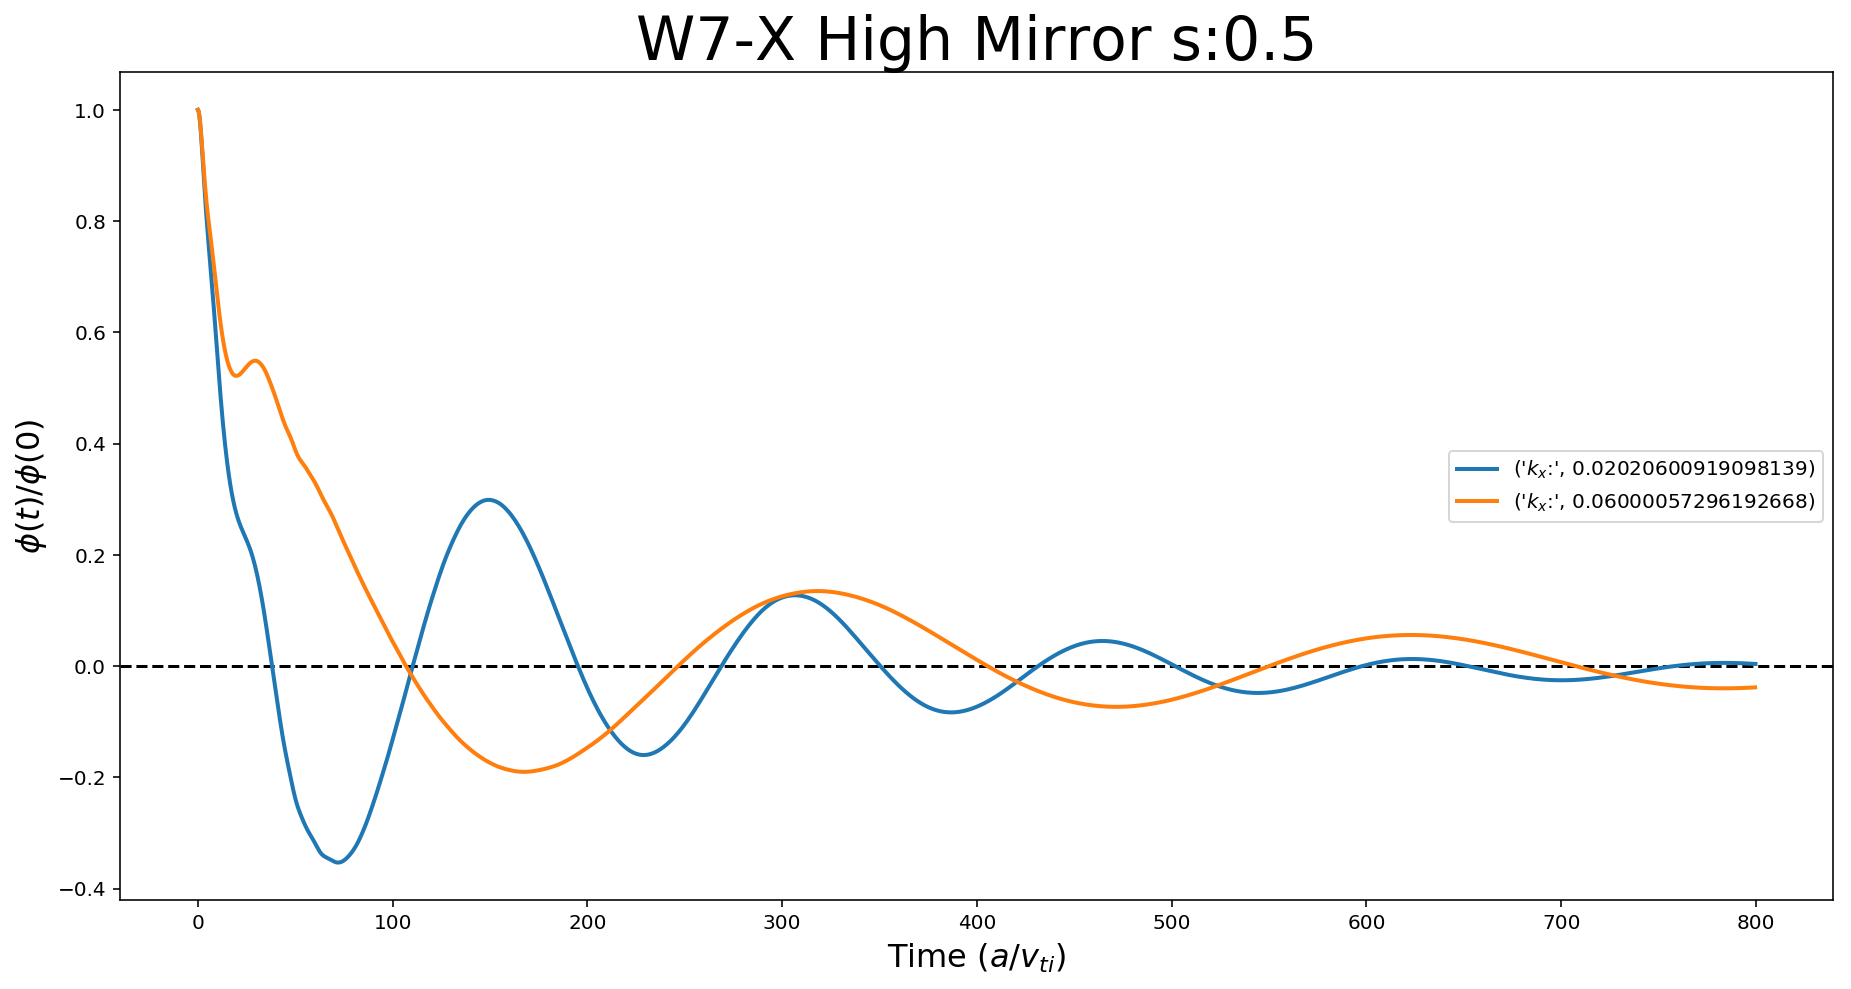

In [4]:
data = pylab.loadtxt('W7Xhms05/GAM/310.957_P/gamdiagions_act.dat')
data2 = pylab.loadtxt('W7Xhms05/GAM/104.719/gamdiagions_act.dat')
mxtime = 800

integ = []
decay = []
osrat = []
dcrat = []
pekti = []
integ2 = []
decay2 = []
osrat2 = []
dcrat2 = []
pekti2 = []

E = (data[:,1]*(1/data[0, 1]))
t = data[:,0]
t_f = (np.abs(t - mxtime)).argmin()
E = E[:t_f]
t = t[:t_f]
E2 = (data2[:,1]*(1/data2[0, 1]))
t2 = data2[:,0]
t_f2 = (np.abs(t2 - mxtime)).argmin()
E2 = E2[:t_f2]
t2 = t2[:t_f2]

fig, ax1 = plt.subplots(figsize=(13, 7))
plt.title('W7-X High Mirror s:0.5', fontsize=30)
#plt.xscale('log')
ax1.set_xlabel('Time ($a / v_{ti}$)',fontsize=16)
ax1.set_ylabel('$\phi (t) / \phi (0)$',fontsize=16)
ax1.axhline(y=0, color='black', linestyle='dashed')
kx1 = 2*(3.1416)/310.957
kx2 = 2*(3.1416)/104.719
lns1 = ax1.plot(t, E, linewidth=2, label=('$k_{x}$:',kx1))
lns2 = ax1.plot(t2, E2, linewidth=2, label=('$k_{x}$:',kx2))
lns = lns1 + lns2
labs = [l.get_label() for l in lns]
plt.legend(lns, labs, loc='center right')
fig.tight_layout()
#plt.savefig('../../CMSS_2018/Poster/Salpha_nlzf_plot.pdf', format='pdf', dpi=1200)    

integ.append(np.trapz(E, t))
integ2.append(np.trapz(E2, t2))

result, OS, DR, TP = nucleus(E, t, diag=False)   
result2, OS2, DR2, TP2 = nucleus(E2, t2, diag=False)   

decay.append(result.best_values.get('decay'))
osrat.append(OS)
dcrat.append(DR)
pekti.append(TP)
decay2.append(result2.best_values.get('decay'))
osrat2.append(OS2)
dcrat2.append(DR2)
pekti2.append(TP2)


In [ ]:
data = pylab.loadtxt('W7Xhiotas05/GAM/665.979/gamdiagions_act.dat')
data2 = pylab.loadtxt('W7Xhiotas05/GAM/104.719/gamdiagions_act.dat')
mxtime = 800

integ = []
decay = []
osrat = []
dcrat = []
pekti = []
integ2 = []
decay2 = []
osrat2 = []
dcrat2 = []
pekti2 = []

E = (data[:,1]*(1/data[0, 1]))
t = data[:,0]
t_f = (np.abs(t - mxtime)).argmin()
E = E[:t_f]
t = t[:t_f]
E2 = (data2[:,1]*(1/data2[0, 1]))
t2 = data2[:,0]
t_f2 = (np.abs(t2 - mxtime)).argmin()
E2 = E2[:t_f2]
t2 = t2[:t_f2]

fig, ax1 = plt.subplots(figsize=(13, 7))
plt.title('W7-X High Iota s:0.5', fontsize=30)
#plt.xscale('log')
ax1.set_xlabel('Time ($a / v_{ti}$)',fontsize=16)
ax1.set_ylabel('$\phi (t) / \phi (0)$',fontsize=16)
ax1.axhline(y=0, color='black', linestyle='dashed')
kx1 = 2*(3.1416)/665.979
kx2 = 2*(3.1416)/104.719
lns1 = ax1.plot(t, E, linewidth=2, label=('$k_{x}$:',kx1))
lns2 = ax1.plot(t2, E2, linewidth=2, label=('$k_{x}$:',kx2))
lns = lns1 + lns2
labs = [l.get_label() for l in lns]
plt.legend(lns, labs, loc='center right')
fig.tight_layout()
#plt.savefig('../../CMSS_2018/Poster/Salpha_nlzf_plot.pdf', format='pdf', dpi=1200)    

integ.append(np.trapz(E, t))
integ2.append(np.trapz(E2, t2))

result, OS, DR, TP = nucleus(E, t, diag=False)   
result2, OS2, DR2, TP2 = nucleus(E2, t2, diag=False)   

decay.append(result.best_values.get('decay'))
osrat.append(OS)
dcrat.append(DR)
pekti.append(TP)
decay2.append(result2.best_values.get('decay'))
osrat2.append(OS2)
dcrat2.append(DR2)
pekti2.append(TP2)



In [ ]:
data = pylab.loadtxt('W7Xhiotas05/GAM/665.979/gamdiagions_act.dat')
data2 = pylab.loadtxt('W7Xhiotas05/GAM/104.719/gamdiagions_act.dat')
mxtime = 800

integ = []
decay = []
osrat = []
dcrat = []
pekti = []
integ2 = []
decay2 = []
osrat2 = []
dcrat2 = []
pekti2 = []

E = (data[:,1]*(1/data[0, 1]))
t = data[:,0]
t_f = (np.abs(t - mxtime)).argmin()
E = E[:t_f]
t = t[:t_f]
E2 = (data2[:,1]*(1/data2[0, 1]))
t2 = data2[:,0]
t_f2 = (np.abs(t2 - mxtime)).argmin()
E2 = E2[:t_f2]
t2 = t2[:t_f2]

fig, ax1 = plt.subplots(figsize=(13, 7))
plt.title('W7-X High Mirror s:0.5', fontsize=30)
#plt.xscale('log')
ax1.set_xlabel('Time ($a / v_{ti}$)',fontsize=16)
ax1.set_ylabel('$\phi (t) / \phi (0)$',fontsize=16)
ax1.axhline(y=0, color='black', linestyle='dashed')
kx1 = 2*(3.1416)/310.957
kx2 = 2*(3.1416)/104.719
lns1 = ax1.plot(t, E, linewidth=2, label=('$k_{x}$:',kx1))
lns2 = ax1.plot(t2, E2, linewidth=2, label=('$k_{x}$:',kx2))
lns = lns1 + lns2
labs = [l.get_label() for l in lns]
plt.legend(lns, labs, loc='center right')
fig.tight_layout()
#plt.savefig('../../CMSS_2018/Poster/Salpha_nlzf_plot.pdf', format='pdf', dpi=1200)    

integ.append(np.trapz(E, t))
integ2.append(np.trapz(E2, t2))

result, OS, DR, TP = nucleus(E, t, diag=False)   
result2, OS2, DR2, TP2 = nucleus(E2, t2, diag=False)   

decay.append(result.best_values.get('decay'))
osrat.append(OS)
dcrat.append(DR)
pekti.append(TP)
decay2.append(result2.best_values.get('decay'))
osrat2.append(OS2)
dcrat2.append(DR2)
pekti2.append(TP2)


